# Dependency Installation

## Shark

In [1]:
!apt-get update > /dev/null 2>&1
!apt-get install -y cmake g++ git libblas-dev liblapack-dev libatlas-base-dev > /dev/null 2>&1

!git clone https://github.com/Shark-ML/Shark.git > /dev/null 2>&1
!mkdir Shark/build > /dev/null 2>&1
!cd Shark/build && cmake .. > /dev/null 2>&1 && make -j$(nproc) > /dev/null 2>&1
!cd Shark/build && sudo make install > /dev/null 2>&1
!sudo ldconfig > /dev/null 2>&1

In [2]:
!ls /content/Shark

appveyor.yml	cmake_uninstall.cmake.in  docs	      SharkConfig.cmake.in	   update_remora.sh
build		COPYING			  examples    SharkConfigVersion.cmake.in  UseShark.cmake
cBlasCheck.cpp	COPYING.LESSER		  include     src
CMakeLists.txt	CTestConfig.cmake	  README.txt  Test


In [3]:
!ls /usr/local/include/shark

Algorithms  Core  Data	LinAlg	Models	ObjectiveFunctions  Statistics	Unsupervised


In [4]:
!find /usr/local/include/shark/Data

/usr/local/include/shark/Data
/usr/local/include/shark/Data/Dataset.h
/usr/local/include/shark/Data/Impl
/usr/local/include/shark/Data/Impl/Dataset.inl
/usr/local/include/shark/Data/Impl/BoostFusion151DefineStructInl.hpp
/usr/local/include/shark/Data/Impl/BoostFusionCopy.hpp
/usr/local/include/shark/Data/Impl/Statistics.inl
/usr/local/include/shark/Data/SparseData.h
/usr/local/include/shark/Data/ExportKernelMatrix.h
/usr/local/include/shark/Data/DataView.h
/usr/local/include/shark/Data/WeightedDataset.h
/usr/local/include/shark/Data/Csv.h
/usr/local/include/shark/Data/Statistics.h
/usr/local/include/shark/Data/LabelOrder.h
/usr/local/include/shark/Data/Download.h
/usr/local/include/shark/Data/Libsvm.h
/usr/local/include/shark/Data/CVDatasetTools.h
/usr/local/include/shark/Data/BatchInterfaceAdaptStruct.h
/usr/local/include/shark/Data/Pgm.h
/usr/local/include/shark/Data/BatchInterface.h
/usr/local/include/shark/Data/DeviceSupport.h
/usr/local/include/shark/Data/DataDistribution.h


In [5]:
!find /usr/local/include/shark -type f -name Shark.h

/usr/local/include/shark/Core/Shark.h


## MLPack

In [6]:
%%bash
sudo apt-get update > /dev/null 2>&1
sudo apt-get install -y libmlpack-dev > /dev/null 2>&1
sudo apt-get install -y libensmallen-dev > /dev/null 2>&1
sudo apt-get install -y libspdlog-dev > /dev/null 2>&1
sudo apt-get install -y libmetis-dev > /dev/null 2>&1
sudo apt-get install libboost-serialization-dev > /dev/null 2>&1

In [7]:
!wget -O cpp_plugin.py https://gist.github.com/akshaykhadse/7acc91dd41f52944c6150754e5530c4b/raw/cpp_plugin.py > /dev/null 2>&1

In [8]:
%load_ext cpp_plugin

# Data Download

In [9]:
%%cpp -n load_iris.cpp -s monokai
#include <iostream>
#include <fstream>
#include <cstdlib>
#include <string>

int main() {
    // URL for the Iris dataset from the UCI repository
    std::string url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data";
    std::string rawFile = "iris.data";
    std::string csvFile = "iris.csv";

    // Check if the raw file exists; if not, download it
    std::ifstream infile(rawFile);
    if (!infile.good()) {
        std::cout << "Downloading Iris dataset..." << std::endl;
        int ret = std::system(("wget " + url + " -O " + rawFile).c_str());
        if (ret != 0) {
            std::cerr << "Error: Failed to download dataset." << std::endl;
            return 1;
        }
    }
    infile.close();

    // Open the raw dataset file for reading
    std::ifstream fin(rawFile);
    if (!fin.is_open()) {
        std::cerr << "Error: Unable to open the downloaded file." << std::endl;
        return 1;
    }

    // Open the CSV file for writing and add a header row
    std::ofstream fout(csvFile);
    if (!fout.is_open()) {
        std::cerr << "Error: Unable to create CSV file." << std::endl;
        return 1;
    }

    // Write header row to CSV
    fout << "sepal_length,sepal_width,petal_length,petal_width,class\n";

    // Read the raw file and write non-empty lines to the CSV file
    std::string line;
    while (std::getline(fin, line)) {
        if (line.empty())
            continue;
        fout << line << "\n";
    }

    fin.close();
    fout.close();

    std::cout << "Iris dataset has been saved as " << csvFile << std::endl;
    return 0;
}

In [10]:
!g++ -std=c++17 -O2 load_iris.cpp -o load_iris

In [11]:
!./load_iris

Iris dataset has been saved as iris.csv


# Data Splitting

In [12]:
%%cpp -n split_iris.cpp -s monokai
#include <iostream>
#include <fstream>
#include <vector>
#include <string>
#include <random>
#include <algorithm>

int main() {
    // Open the CSV file containing the Iris data
    std::ifstream fin("iris.csv");
    if (!fin.is_open()) {
        std::cerr << "Error: Unable to open iris.csv" << std::endl;
        return 1;
    }

    // Read the header
    std::string header;
    std::getline(fin, header);

    // Read all data lines into a vector
    std::vector<std::string> lines;
    std::string line;
    while (std::getline(fin, line)) {
        if (!line.empty())
            lines.push_back(line);
    }
    fin.close();

    // Shuffle the data randomly using a Mersenne Twister generator
    std::random_device rd;
    std::mt19937 g(rd());
    std::shuffle(lines.begin(), lines.end(), g);

    // Determine split sizes (80% train, 20% test)
    size_t total = lines.size();
    size_t trainSize = static_cast<size_t>(total * 0.8);

    // Write the training set to train_iris.csv
    std::ofstream ftrain("train_iris.csv");
    if (!ftrain.is_open()) {
        std::cerr << "Error: Unable to create train_iris.csv" << std::endl;
        return 1;
    }
    ftrain << header << "\n";
    for (size_t i = 0; i < trainSize; i++) {
        ftrain << lines[i] << "\n";
    }
    ftrain.close();

    // Write the test set to test_iris.csv
    std::ofstream ftest("test_iris.csv");
    if (!ftest.is_open()) {
        std::cerr << "Error: Unable to create test_iris.csv" << std::endl;
        return 1;
    }
    ftest << header << "\n";
    for (size_t i = trainSize; i < total; i++) {
        ftest << lines[i] << "\n";
    }
    ftest.close();

    std::cout << "Random split complete: " << trainSize
              << " training lines, " << (total - trainSize)
              << " test lines" << std::endl;
    return 0;
}

In [13]:
!g++ -std=c++17 -O2 split_iris.cpp -o split_iris

In [14]:
!./split_iris

Random split complete: 120 training lines, 30 test lines


# Data Viewing

In [15]:
%%cpp -n view_csv.cpp -s monokai
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <iomanip>
#include <string>

// Function to split a string using a delimiter
std::vector<std::string> split(const std::string &s, char delimiter) {
    std::vector<std::string> tokens;
    std::string token;
    std::istringstream tokenStream(s);
    while (getline(tokenStream, token, delimiter))
        tokens.push_back(token);
    return tokens;
}

int main() {
    // Open the CSV file for reading
    std::ifstream fin("train_iris.csv");
    if (!fin.is_open()) {
        std::cerr << "Error: Unable to open train_iris.csv" << std::endl;
        return 1;
    }

    // Read the CSV file into a table (vector of vector of strings)
    std::vector<std::vector<std::string>> table;
    std::string line;
    while (getline(fin, line)) {
        if (!line.empty())
            table.push_back(split(line, ','));
    }
    fin.close();

    // Determine maximum width for each column
    std::vector<size_t> colWidths;
    if (!table.empty()) {
        size_t numCols = table[0].size();
        colWidths.resize(numCols, 0);
        for (const auto &row : table) {
            for (size_t i = 0; i < numCols; i++) {
                if (i < row.size() && row[i].length() > colWidths[i])
                    colWidths[i] = row[i].length();
            }
        }
    }

    // Print the table with each column left-aligned and padded
    for (const auto &row : table) {
        for (size_t i = 0; i < row.size(); i++) {
            std::cout << std::setw(colWidths[i] + 2) << std::left << row[i];
        }
        std::cout << std::endl;
    }

    return 0;
}

In [16]:
!g++ -std=c++17 -O2 view_csv.cpp -o view_csv

In [17]:
!./view_csv

sepal_length  sepal_width  petal_length  petal_width  class            
4.7           3.2          1.3           0.2          Iris-setosa      
5.0           2.3          3.3           1.0          Iris-versicolor  
4.8           3.4          1.9           0.2          Iris-setosa      
5.0           3.0          1.6           0.2          Iris-setosa      
5.7           4.4          1.5           0.4          Iris-setosa      
5.8           4.0          1.2           0.2          Iris-setosa      
4.8           3.1          1.6           0.2          Iris-setosa      
6.8           3.2          5.9           2.3          Iris-virginica   
6.7           3.1          4.7           1.5          Iris-versicolor  
4.9           3.1          1.5           0.1          Iris-setosa      
5.6           2.5          3.9           1.1          Iris-versicolor  
6.3           2.9          5.6           1.8          Iris-virginica   
6.0           3.0          4.8           1.8          Iris-virgi

# Shark Modeling

In [18]:
%%cpp -n shark_predict.cpp -s monokai
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <string>
#include <stdexcept>
#include <unordered_map>

// Include the master Shark header and dataset/trainer headers
#include <shark/Core/Shark.h>
#include <shark/Data/Dataset.h>
#include <shark/Algorithms/Trainers/RFTrainer.h>
#include <shark/Algorithms/Trainers/CSvmTrainer.h>

using namespace std;
using namespace shark;

// Custom CSV parser that loads a dataset from a CSV file with a header line
// Assumes each row has numeric features and the label is in the last column
// This version maps string labels ("Iris-setosa", etc.) to numeric values
ClassificationDataset loadDataset(const string& filename) {
    ifstream fin(filename);
    if (!fin.is_open())
        throw runtime_error("Unable to open " + filename);

    string header;
    getline(fin, header); // skip header

    // Mapping from string label to numeric value
    unordered_map<string, unsigned int> labelMap = {
        {"Iris-setosa", 0},
        {"Iris-versicolor", 1},
        {"Iris-virginica", 2}
    };

    vector<RealVector> samples;
    vector<unsigned int> labs;

    string line;
    while(getline(fin, line)) {
        if(line.empty())
            continue;
        istringstream ss(line);
        vector<string> tokens;
        string token;
        while(getline(ss, token, ',')) {
            // Trim leading and trailing whitespace
            size_t start = token.find_first_not_of(" \t");
            size_t end = token.find_last_not_of(" \t");
            string trimmed = (start == string::npos) ? "" : token.substr(start, end - start + 1);
            tokens.push_back(trimmed);
        }
        if(tokens.size() < 2)
            continue;
        // The last token is the label (string)
        string labelStr = tokens.back();
        unsigned int lab;
        auto it = labelMap.find(labelStr);
        if(it != labelMap.end())
            lab = it->second;
        else {
            try {
                lab = static_cast<unsigned int>(stod(labelStr));
            } catch(const exception& e) {
                throw runtime_error("Error converting label token '" + labelStr + "': " + e.what());
            }
        }
        labs.push_back(lab);
        tokens.pop_back(); // remove label

        // Convert remaining tokens to features
        vector<double> feat;
        for(auto& s : tokens) {
            try {
                feat.push_back(stod(s));
            } catch(const exception& e) {
                throw runtime_error("Error converting feature token '" + s + "': " + e.what());
            }
        }
        samples.push_back(RealVector(feat.begin(), feat.end()));
    }
    fin.close();

    if(samples.empty())
        throw runtime_error("No data found in " + filename);

    // Build and return the ClassificationDataset using Shark's helper function
    return createLabeledDataFromRange(samples, labs);
}

int main(){
    try {
        // Load training and test datasets from CSV files
        ClassificationDataset trainData = loadDataset("train_iris.csv");
        ClassificationDataset testData = loadDataset("test_iris.csv");

        // Train a Random Forest classifier on the training data
        RFTrainer<unsigned int> rfTrainer;
        rfTrainer.setNTrees(100);
        rfTrainer.setMinSplit(10);
        rfTrainer.setMaxDepth(10);
        rfTrainer.setNodeSize(5);
        rfTrainer.minImpurity(1.e-10);
        RFClassifier<unsigned int> rf;
        rfTrainer.train(rf, trainData);
        Data<unsigned int> rfPreds = rf(testData.inputs());

        // Train a linear SVM classifier on the training data
        double svmC = 100.0;
        LinearCSvmTrainer<RealVector> svmTrainer(svmC, false);
        LinearClassifier<RealVector> svm;
        svmTrainer.train(svm, trainData);
        Data<unsigned int> svmPreds = svm(testData.inputs());

        // Save predictions to a CSV file called shark_predictions.csv
        ofstream fout("shark_predictions.csv");
        if (!fout.is_open())
            throw runtime_error("Unable to open shark_predictions.csv for writing");
        fout << "Sample,RF_Prediction,SVM_Prediction\n";
        size_t n = testData.numberOfElements();
        for (size_t i = 0; i < n; i++) {
            fout << i << "," << rfPreds.element(i) << "," << svmPreds.element(i) << "\n";
        }
        fout.close();
        cout << "Predictions saved to shark_predictions.csv" << endl;
    } catch(const exception& e) {
        cerr << "Error: " << e.what() << endl;
        return 1;
    }
    return 0;
}

In [19]:
!g++ -std=c++17 -O2 shark_predict.cpp -o shark_predict -I/usr/local/include -L/usr/local/lib -DBOOST_BIND_GLOBAL_PLACEHOLDERS -lshark -lboost_serialization -lcblas -lblas

In [20]:
!./shark_predict

Predictions saved to shark_predictions.csv


In [21]:
!ls /content/shark_predictions.csv
!cat /content/shark_predictions.csv

/content/shark_predictions.csv
Sample,RF_Prediction,SVM_Prediction
0,1,1
1,2,2
2,2,2
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,1,1
9,0,0
10,2,2
11,2,1
12,2,2
13,0,0
14,0,0
15,0,0
16,1,2
17,2,2
18,1,1
19,2,1
20,0,0
21,1,1
22,2,2
23,1,1
24,0,0
25,1,1
26,0,0
27,0,0
28,2,2
29,2,2


# MLPack Modeling

In [22]:
%%cpp -n mlpack_predict.cpp -s monokai
#include <mlpack/core.hpp>
#include <mlpack/methods/random_forest/random_forest.hpp>
#include <mlpack/methods/linear_svm/linear_svm.hpp>
#include <iostream>
#include <fstream>
#include <sstream>
#include <vector>
#include <map>

using namespace std;
using namespace arma;
using namespace mlpack;
using namespace mlpack::tree;
using namespace mlpack::svm;

// Function to load the Iris CSV file (with header)
// Expects each row to have 5 comma-separated fields: 4 numeric features and 1 label (last column)
// Maps string labels to integers (Iris-setosa -> 0, Iris-versicolor -> 1, Iris-virginica -> 2)
// Returns the features as an arma::mat (each column is a sample) and labels as an arma::Row<size_t>
bool LoadIrisData(const std::string& filename, arma::mat& features, arma::Row<size_t>& labels)
{
  std::ifstream fin(filename);
  if (!fin.is_open())
  {
    std::cerr << "Error: Unable to open " << filename << std::endl;
    return false;
  }
  // Read and ignore header
  std::string header;
  std::getline(fin, header);

  std::vector< std::vector<double> > dataRows;
  std::vector<size_t> labelVec;
  std::string line;

  // Mapping from label strings to integers
  std::map<std::string, size_t> labelMap = {
    {"Iris-setosa", 0},
    {"Iris-versicolor", 1},
    {"Iris-virginica", 2}
  };

  while (std::getline(fin, line))
  {
    if (line.empty())
      continue;
    std::istringstream iss(line);
    std::string token;
    std::vector<std::string> tokens;
    while(getline(iss, token, ','))
    {
      // Trim whitespace
      size_t start = token.find_first_not_of(" \t");
      size_t end = token.find_last_not_of(" \t");
      std::string trimmed = (start == std::string::npos) ? "" : token.substr(start, end - start + 1);
      tokens.push_back(trimmed);
    }
    if (tokens.size() != 5)
      continue; // Skip if not exactly 5 tokens
    // Extract the first 4 tokens as features
    std::vector<double> featuresRow;
    for (size_t i = 0; i < 4; i++)
    {
      featuresRow.push_back(std::stod(tokens[i]));
    }
    dataRows.push_back(featuresRow);
    // Map the label string to an integer
    auto it = labelMap.find(tokens[4]);
    if (it != labelMap.end())
      labelVec.push_back(it->second);
    else
      labelVec.push_back(0); // Default value if not found
  }
  fin.close();

  size_t numSamples = dataRows.size();
  if (numSamples == 0)
  {
    std::cerr << "Error: No data loaded from " << filename << std::endl;
    return false;
  }
  size_t numFeatures = dataRows[0].size();

  // Create an Armadillo matrix with samples as columns
  features.set_size(numFeatures, numSamples);
  for (size_t i = 0; i < numSamples; i++)
  {
    for (size_t j = 0; j < numFeatures; j++)
    {
      features(j, i) = dataRows[i][j];
    }
  }
  labels = arma::conv_to< arma::Row<size_t> >::from(arma::Col<size_t>(labelVec));
  return true;
}

int main()
{
  // Load training data from train_iris.csv
  arma::mat trainFeatures;
  arma::Row<size_t> trainLabels;
  if (!LoadIrisData("train_iris.csv", trainFeatures, trainLabels))
  {
    std::cerr << "Error loading training data" << std::endl;
    return 1;
  }

  // Load test data from test_iris.csv
  arma::mat testFeatures;
  arma::Row<size_t> testLabels;
  if (!LoadIrisData("test_iris.csv", testFeatures, testLabels))
  {
    std::cerr << "Error loading test data" << std::endl;
    return 1;
  }

  // Debug: Print dimensions of loaded data
  std::cout << "Training features size: " << trainFeatures.n_rows << " x " << trainFeatures.n_cols << std::endl;
  std::cout << "Test features size: " << testFeatures.n_rows << " x " << testFeatures.n_cols << std::endl;

  // Train a Random Forest model on the training data (no augmentation needed)
  const size_t numTrees = 50;
  const size_t minimumLeafSize = 5;
  RandomForest<> rf(trainFeatures, trainLabels, numTrees, minimumLeafSize);
  arma::Row<size_t> rfPredictions;
  rf.Classify(testFeatures, rfPredictions);

  // Set parameters for Linear SVM
  const size_t numClasses = 3;
  const double lambda = 0.1;
  const double delta = 1e-5;
  // Set fitIntercept to false so that the model uses the data as-is (4 features)
  const bool fitIntercept = false;

  // Create a default LinearSVM object, then set parameters and train
  LinearSVM<> svm;
  svm.Lambda() = lambda;
  svm.Delta() = delta;
  svm.FitIntercept() = fitIntercept;

  // Train the SVM using the unaugmented training data
  svm.Train(trainFeatures, trainLabels, numClasses);

  arma::Row<size_t> svmPredictions;
  svm.Classify(testFeatures, svmPredictions);

  // Save predictions to a CSV file
  std::ofstream fout("mlpack_predictions.csv");
  if (!fout.is_open())
  {
    std::cerr << "Error: Unable to open mlpack_predictions.csv for writing" << std::endl;
    return 1;
  }
  fout << "Sample,RF_Prediction,SVM_Prediction\n";
  size_t n = testFeatures.n_cols;
  for (size_t i = 0; i < n; i++)
  {
    fout << i << "," << rfPredictions(i) << "," << svmPredictions(i) << "\n";
  }
  fout.close();

  std::cout << "Predictions saved to mlpack_predictions.csv" << std::endl;
  return 0;
}

In [23]:
!g++ -std=c++17 -O2 mlpack_predict.cpp -o mlpack_predict -lmlpack -larmadillo -fopenmp

In [24]:
!./mlpack_predict

Training features size: 4 x 120
Test features size: 4 x 30
Predictions saved to mlpack_predictions.csv


In [25]:
!ls /content/mlpack_predictions.csv
!cat /content/mlpack_predictions.csv

/content/mlpack_predictions.csv
Sample,RF_Prediction,SVM_Prediction
0,1,1
1,1,2
2,2,2
3,1,1
4,0,0
5,1,0
6,0,0
7,1,1
8,1,1
9,0,0
10,2,2
11,2,1
12,1,2
13,0,0
14,0,0
15,0,0
16,1,2
17,2,2
18,1,1
19,2,1
20,0,0
21,1,1
22,2,2
23,1,1
24,0,0
25,1,1
26,0,0
27,0,0
28,2,2
29,1,2


# Evaluation Metrics

In [26]:
!ls /content/train_iris.csv
!cat /content/train_iris.csv

/content/train_iris.csv
sepal_length,sepal_width,petal_length,petal_width,class
4.7,3.2,1.3,0.2,Iris-setosa
5.0,2.3,3.3,1.0,Iris-versicolor
4.8,3.4,1.9,0.2,Iris-setosa
5.0,3.0,1.6,0.2,Iris-setosa
5.7,4.4,1.5,0.4,Iris-setosa
5.8,4.0,1.2,0.2,Iris-setosa
4.8,3.1,1.6,0.2,Iris-setosa
6.8,3.2,5.9,2.3,Iris-virginica
6.7,3.1,4.7,1.5,Iris-versicolor
4.9,3.1,1.5,0.1,Iris-setosa
5.6,2.5,3.9,1.1,Iris-versicolor
6.3,2.9,5.6,1.8,Iris-virginica
6.0,3.0,4.8,1.8,Iris-virginica
5.7,2.5,5.0,2.0,Iris-virginica
6.3,3.3,6.0,2.5,Iris-virginica
7.3,2.9,6.3,1.8,Iris-virginica
5.1,3.8,1.6,0.2,Iris-setosa
6.9,3.2,5.7,2.3,Iris-virginica
4.7,3.2,1.6,0.2,Iris-setosa
6.0,2.7,5.1,1.6,Iris-versicolor
4.9,3.1,1.5,0.1,Iris-setosa
6.4,3.1,5.5,1.8,Iris-virginica
6.7,3.1,5.6,2.4,Iris-virginica
7.4,2.8,6.1,1.9,Iris-virginica
5.4,3.4,1.5,0.4,Iris-setosa
6.5,3.0,5.8,2.2,Iris-virginica
5.7,3.8,1.7,0.3,Iris-setosa
6.1,2.6,5.6,1.4,Iris-virginica
5.8,2.7,5.1,1.9,Iris-virginica
6.6,3.0,4.4,1.4,Iris-versicolor
4.8,3.4,1.6,0.2,Iris-

In [27]:
%%cpp -n evaluation_metrics.cpp -s monokai
#include <fstream>
#include <iostream>
#include <sstream>
#include <string>
#include <vector>
#include <map>
#include <iomanip> // for std::setprecision

using namespace std;

// Map label string to integer
int StringToLabel(const string& labelStr)
{
  if (labelStr == "Iris-setosa")
    return 0;
  else if (labelStr == "Iris-versicolor")
    return 1;
  else if (labelStr == "Iris-virginica")
    return 2;
  else
    return -1; // unknown
}

// Reads test_iris.csv and extracts the true labels from the last column
// Assumes the first line is a header and each row is comma-separated
bool LoadTrueLabels(const string& filename, vector<int>& trueLabels)
{
  ifstream fin(filename);
  if (!fin.is_open())
  {
    cerr << "Error: Could not open " << filename << endl;
    return false;
  }
  string line;
  // Read header line
  getline(fin, line);
  while(getline(fin, line))
  {
    if(line.empty())
      continue;
    istringstream ss(line);
    string token;
    vector<string> tokens;
    while(getline(ss, token, ','))
      tokens.push_back(token);
    if (!tokens.empty())
    {
      int lab = StringToLabel(tokens.back());
      if(lab == -1)
        cerr << "Warning: unknown label: " << tokens.back() << endl;
      trueLabels.push_back(lab);
    }
  }
  fin.close();
  return true;
}

// Reads a predictions file with header "Sample,RF_Prediction,SVM_Prediction"
// Returns two vectors for RF and SVM predictions respectively
bool LoadPredictions(const string& filename, vector<int>& rfPred, vector<int>& svmPred)
{
  ifstream fin(filename);
  if (!fin.is_open())
  {
    cerr << "Error: Could not open " << filename << endl;
    return false;
  }
  string line;
  // Read header line
  getline(fin, line);
  while(getline(fin, line))
  {
    if(line.empty())
      continue;
    istringstream ss(line);
    string token;
    vector<string> tokens;
    while(getline(ss, token, ','))
      tokens.push_back(token);
    // Expect 3 tokens: Sample,RF_Prediction,SVM_Prediction
    if(tokens.size() != 3)
      continue;
    rfPred.push_back(stoi(tokens[1]));
    svmPred.push_back(stoi(tokens[2]));
  }
  fin.close();
  return true;
}

// Compute evaluation metrics given true and predicted labels
// Accuracy is the fraction of correct predictions
// Macro-averaged precision, recall and F1 score are computed over the three classes
void ComputeMetrics(const vector<int>& trueLabels, const vector<int>& pred,
                    double& accuracy, double& macroPrecision,
                    double& macroRecall, double& macroF1)
{
  if (trueLabels.size() != pred.size() || trueLabels.empty())
  {
    cerr << "Error: Mismatch in vector sizes or empty vector" << endl;
    return;
  }
  size_t N = trueLabels.size();
  size_t correct = 0;
  for (size_t i = 0; i < N; ++i)
  {
    if (trueLabels[i] == pred[i])
      ++correct;
  }
  accuracy = (double) correct / N;

  int numClasses = 3;
  vector<double> precisionPerClass(numClasses, 0.0);
  vector<double> recallPerClass(numClasses, 0.0);
  vector<double> f1PerClass(numClasses, 0.0);

  for (int c = 0; c < numClasses; c++)
  {
    int TP = 0, FP = 0, FN = 0;
    for (size_t i = 0; i < N; i++)
    {
      if (pred[i] == c && trueLabels[i] == c)
        TP++;
      if (pred[i] == c && trueLabels[i] != c)
        FP++;
      if (pred[i] != c && trueLabels[i] == c)
        FN++;
    }
    precisionPerClass[c] = (TP + FP > 0) ? (double) TP / (TP + FP) : 0.0;
    recallPerClass[c] = (TP + FN > 0) ? (double) TP / (TP + FN) : 0.0;
    if (precisionPerClass[c] + recallPerClass[c] > 0)
      f1PerClass[c] = 2 * precisionPerClass[c] * recallPerClass[c] / (precisionPerClass[c] + recallPerClass[c]);
    else
      f1PerClass[c] = 0.0;
  }

  double sumP = 0, sumR = 0, sumF1 = 0;
  for (int c = 0; c < numClasses; c++)
  {
    sumP += precisionPerClass[c];
    sumR += recallPerClass[c];
    sumF1 += f1PerClass[c];
  }
  macroPrecision = sumP / numClasses;
  macroRecall = sumR / numClasses;
  macroF1 = sumF1 / numClasses;
}

int main()
{
  // Define file paths
  string trueFile = "/content/test_iris.csv"; // Test set with true labels in the last column
  string sharkPredFile = "/content/shark_predictions.csv"; // Predictions from the shark model
  string mlpackPredFile = "/content/mlpack_predictions.csv"; // Predictions from the mlpack model
  string outputFile = "/content/evaluation_metrics.csv";

  // Load true labels from test_iris.csv
  vector<int> trueLabels;
  if (!LoadTrueLabels(trueFile, trueLabels))
  {
    cerr << "Failed to load true labels" << endl;
    return 1;
  }

  // Load predictions from shark_predictions.csv
  vector<int> sharkRFPred, sharkSVMPred;
  if (!LoadPredictions(sharkPredFile, sharkRFPred, sharkSVMPred))
  {
    cerr << "Failed to load shark predictions" << endl;
    return 1;
  }

  // Load predictions from mlpack_predictions.csv
  vector<int> mlpackRFPred, mlpackSVMPred;
  if (!LoadPredictions(mlpackPredFile, mlpackRFPred, mlpackSVMPred))
  {
    cerr << "Failed to load mlpack predictions" << endl;
    return 1;
  }

  // Ensure sample counts match
  if (trueLabels.size() != sharkRFPred.size() ||
      trueLabels.size() != mlpackRFPred.size())
  {
    cerr << "Mismatch in number of samples among files" << endl;
    return 1;
  }

  double acc, prec, rec, f1;

  // Create evaluation_metrics.csv with columns: PredictionFile,Model,Accuracy,Precision,Recall,F1
  ofstream fout(outputFile);
  if (!fout.is_open())
  {
    cerr << "Error: Unable to open " << outputFile << " for writing" << endl;
    return 1;
  }
  fout << "PredictionFile,Model,Accuracy,Precision,Recall,F1\n";
  fout << fixed << setprecision(4);

  // Shark predictions: Random Forest
  ComputeMetrics(trueLabels, sharkRFPred, acc, prec, rec, f1);
  fout << "shark_predictions.csv,RF," << acc << "," << prec << "," << rec << "," << f1 << "\n";

  // Shark predictions: SVM
  ComputeMetrics(trueLabels, sharkSVMPred, acc, prec, rec, f1);
  fout << "shark_predictions.csv,SVM," << acc << "," << prec << "," << rec << "," << f1 << "\n";

  // mlpack predictions: Random Forest
  ComputeMetrics(trueLabels, mlpackRFPred, acc, prec, rec, f1);
  fout << "mlpack_predictions.csv,RF," << acc << "," << prec << "," << rec << "," << f1 << "\n";

  // mlpack predictions: SVM
  ComputeMetrics(trueLabels, mlpackSVMPred, acc, prec, rec, f1);
  fout << "mlpack_predictions.csv,SVM," << acc << "," << prec << "," << rec << "," << f1 << "\n";

  fout.close();
  cout << "Evaluation metrics saved to " << outputFile << endl;
  return 0;
}

In [28]:
!g++ -std=c++17 -O2 evaluation_metrics.cpp -o evaluation_metrics

In [29]:
!./evaluation_metrics

Evaluation metrics saved to /content/evaluation_metrics.csv


In [30]:
!cat /content/evaluation_metrics.csv

PredictionFile,Model,Accuracy,Precision,Recall,F1
shark_predictions.csv,RF,0.9667,0.9667,0.9697,0.9666
shark_predictions.csv,SVM,0.9333,0.9394,0.9394,0.9333
mlpack_predictions.csv,RF,0.8667,0.8974,0.8788,0.8653
mlpack_predictions.csv,SVM,0.9000,0.9030,0.9024,0.8982


In [31]:
%%cpp -n display_table.cpp -s monokai
#include <fstream>
#include <iostream>
#include <sstream>
#include <string>
#include <vector>
#include <iomanip>
#include <algorithm>

using namespace std;

// Structure to hold one evaluation result
struct Result {
  string predictionFile;
  string model;
  double accuracy;
  double precision;
  double recall;
  double f1;
};

// Split a string by a delimiter and return tokens
vector<string> split(const string &s, char delimiter) {
  vector<string> tokens;
  istringstream ss(s);
  string token;
  while(getline(ss, token, delimiter))
    tokens.push_back(token);
  return tokens;
}

int main() {
  string filename = "/content/evaluation_metrics.csv";
  ifstream fin(filename);
  if (!fin.is_open()) {
    cerr << "Error: Could not open " << filename << endl;
    return 1;
  }

  string line;
  // Read header and discard it
  getline(fin, line);

  vector<Result> results;
  while(getline(fin, line)) {
    if(line.empty())
      continue;
    vector<string> tokens = split(line, ',');
    if(tokens.size() != 6)
      continue;
    Result r;
    r.predictionFile = tokens[0];
    r.model = tokens[1];
    r.accuracy = stod(tokens[2]);
    r.precision = stod(tokens[3]);
    r.recall = stod(tokens[4]);
    r.f1 = stod(tokens[5]);
    results.push_back(r);
  }
  fin.close();

  // Sort results by predictionFile then by model
  sort(results.begin(), results.end(), [](const Result &a, const Result &b) {
    if (a.predictionFile == b.predictionFile)
      return a.model < b.model;
    return a.predictionFile < b.predictionFile;
  });

  // Display table header
  const int colWidth1 = 25;
  const int colWidth2 = 10;
  const int colWidth3 = 10;
  const int colWidth4 = 10;
  const int colWidth5 = 10;
  const int colWidth6 = 10;

  cout << left << setw(colWidth1) << "PredictionFile"
       << setw(colWidth2) << "Model"
       << setw(colWidth3) << "Accuracy"
       << setw(colWidth4) << "Precision"
       << setw(colWidth5) << "Recall"
       << setw(colWidth6) << "F1" << endl;

  cout << string(colWidth1 + colWidth2 + colWidth3 + colWidth4 + colWidth5 + colWidth6, '-') << endl;

  // Display each row
  for (const auto &r : results) {
    cout << left << setw(colWidth1) << r.predictionFile
         << setw(colWidth2) << r.model
         << setw(colWidth3) << fixed << setprecision(4) << r.accuracy
         << setw(colWidth4) << fixed << setprecision(4) << r.precision
         << setw(colWidth5) << fixed << setprecision(4) << r.recall
         << setw(colWidth6) << fixed << setprecision(4) << r.f1
         << endl;
  }

  return 0;
}

In [32]:
!g++ -std=c++17 -O2 display_table.cpp -o display_table

In [33]:
!./display_table

PredictionFile           Model     Accuracy  Precision Recall    F1        
---------------------------------------------------------------------------
mlpack_predictions.csv   RF        0.8667    0.8974    0.8788    0.8653    
mlpack_predictions.csv   SVM       0.9000    0.9030    0.9024    0.8982    
shark_predictions.csv    RF        0.9667    0.9667    0.9697    0.9666    
shark_predictions.csv    SVM       0.9333    0.9394    0.9394    0.9333    


# Plotting Metrics

In [34]:
!git clone https://github.com/alandefreitas/matplotplusplus.git > /dev/null 2>&1
!cd matplotplusplus && mkdir -p build && cd build && cmake .. > /dev/null 2>&1 && make -j4 > /dev/null 2>&1
!apt-get install -y gnuplot > /dev/null 2>&1

In [35]:
%%cpp -n plot_metrics.cpp -s monokai
#include <fstream>
#include <iostream>
#include <sstream>
#include <string>
#include <vector>
#include <iomanip>
#include <algorithm>
#include <iterator>
#include <cstdio>
#include <cstdlib>

using namespace std;

// Base64 encoding table
static const string base64_chars =
    "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    "abcdefghijklmnopqrstuvwxyz"
    "0123456789+/";

string base64_encode(const unsigned char* bytes_to_encode, size_t in_len) {
    string ret;
    int i = 0;
    int j = 0;
    unsigned char char_array_3[3];
    unsigned char char_array_4[4];

    while (in_len--) {
        char_array_3[i++] = *(bytes_to_encode++);
        if (i == 3) {
            char_array_4[0] = (char_array_3[0] & 0xfc) >> 2;
            char_array_4[1] = ((char_array_3[0] & 0x03) << 4) + ((char_array_3[1] & 0xf0) >> 4);
            char_array_4[2] = ((char_array_3[1] & 0x0f) << 2) + ((char_array_3[2] & 0xc0) >> 6);
            char_array_4[3] = char_array_3[2] & 0x3f;

            for (i = 0; i < 4; i++)
                ret += base64_chars[char_array_4[i]];
            i = 0;
        }
    }

    if (i) {
        for (j = i; j < 3; j++)
            char_array_3[j] = '\0';

        char_array_4[0] = (char_array_3[0] & 0xfc) >> 2;
        char_array_4[1] = ((char_array_3[0] & 0x03) << 4) + ((char_array_3[1] & 0xf0) >> 4);
        char_array_4[2] = ((char_array_3[1] & 0x0f) << 2) + ((char_array_3[2] & 0xc0) >> 6);
        char_array_4[3] = char_array_3[2] & 0x3f;

        for (j = 0; j < i + 1; j++)
            ret += base64_chars[char_array_4[j]];

        while (i++ < 3)
            ret += '=';
    }

    return ret;
}

struct Result {
    string predictionFile;
    string model;
    double accuracy;
    double precision;
    double recall;
    double f1;
};

// Split a string by a delimiter
vector<string> split(const string &s, char delimiter) {
    vector<string> tokens;
    istringstream ss(s);
    string token;
    while (getline(ss, token, delimiter)) {
        // Trim whitespace
        while (!token.empty() && (token.front() == ' ' || token.front() == '\t'))
            token.erase(token.begin());
        while (!token.empty() && (token.back() == ' ' || token.back() == '\t'))
            token.pop_back();

        tokens.push_back(token);
    }
    return tokens;
}

// Map "mlpack_predictions_RF" -> "MLP_RF", etc.
string simplifyLabel(const string &cat) {
    if (cat == "mlpack_predictions_RF")   return "MLPack-RF";
    if (cat == "mlpack_predictions_SVM")  return "MLPack-SVM";
    if (cat == "shark_predictions_RF")    return "Shark-RF";
    if (cat == "shark_predictions_SVM")   return "Shark-SVM";
    return cat; // fallback
}

int main() {
    string filename = "/content/evaluation_metrics.csv";
    ifstream fin(filename);
    if (!fin.is_open()) {
        cerr << "Error: Could not open " << filename << endl;
        return 1;
    }

    // Skip the header line
    string line;
    getline(fin, line);

    vector<Result> results;
    while (true) {
        if (!getline(fin, line)) break;
        if (line.empty())
            continue;

        vector<string> tokens = split(line, ',');
        if (tokens.size() < 6)
            continue;

        try {
            Result r;
            r.predictionFile = tokens[0];
            r.model          = tokens[1];
            r.accuracy       = stod(tokens[2]);
            r.precision      = stod(tokens[3]);
            r.recall         = stod(tokens[4]);
            r.f1             = stod(tokens[5]);
            results.push_back(r);
        } catch (...) {
            continue;
        }
    }
    fin.close();

    // Create categories
    vector<string> categories;
    vector<double> acc_vals, prec_vals, recall_vals, f1_vals;

    for (auto &r : results) {
        size_t pos = r.predictionFile.find(".csv");
        string lib = (pos != string::npos) ? r.predictionFile.substr(0, pos) : r.predictionFile;
        string cat = lib + "_" + r.model;
        categories.push_back(cat);
        acc_vals.push_back(r.accuracy);
        prec_vals.push_back(r.precision);
        recall_vals.push_back(r.recall);
        f1_vals.push_back(r.f1);
    }

    // Sort them by category name
    vector<size_t> indices(categories.size());
    for (size_t i = 0; i < indices.size(); i++)
        indices[i] = i;

    sort(indices.begin(), indices.end(), [&categories](size_t i1, size_t i2) {
        return categories[i1] < categories[i2];
    });

    // Write data file for gnuplot
    ofstream dataFile("/content/plot_data.dat");
    if (!dataFile.is_open()) {
        cerr << "Error: Could not create /content/plot_data.dat" << endl;
        return 1;
    }
    dataFile << "#Group Accuracy Precision Recall F1\n";
    for (size_t idx : indices) {
        // Use short label
        string shortLabel = simplifyLabel(categories[idx]);
        dataFile << shortLabel << " "
                 << fixed << setprecision(4) << acc_vals[idx] << " "
                 << fixed << setprecision(4) << prec_vals[idx] << " "
                 << fixed << setprecision(4) << recall_vals[idx] << " "
                 << fixed << setprecision(4) << f1_vals[idx] << "\n";
    }
    dataFile.close();

    // Create a gnuplot script
    ofstream gpFile("/content/plot.gp");
    if (!gpFile.is_open()) {
        cerr << "Error: Could not create /content/plot.gp" << endl;
        return 1;
    }

    gpFile << "set terminal pngcairo size 1200,600 enhanced font 'Verdana,12'\n";
    gpFile << "set output 'evaluation_metrics.png'\n";
    gpFile << "set style data histogram\n";
    // Increase gap so bars have more space from x-axis
    gpFile << "set style histogram clustered gap 3\n";
    gpFile << "set style fill solid border -1\n";
    gpFile << "set boxwidth 0.7\n";

    gpFile << "set title 'Evaluation Metrics for Each Model'\n";
    gpFile << "set ylabel 'Metric Value'\n";
    gpFile << "set grid ytics\n";
    gpFile << "set key outside\n";
    // Larger bottom margin
    gpFile << "set bmargin 6\n";
    // Rotate by -45, anchor to center, shift labels down by 1 line
    gpFile << "set xtics rotate by -45 center offset 0,-1.5\n";
    gpFile << "set xtics font ',10'\n";

    // Plot
    gpFile << "plot '/content/plot_data.dat' using 2:xtic(1) title 'Accuracy', \\\n";
    gpFile << "     '' using 3 title 'Precision', \\\n";
    gpFile << "     '' using 4 title 'Recall', \\\n";
    gpFile << "     '' using 5 title 'F1'\n";
    gpFile.close();

    // Run gnuplot
    int ret = system("gnuplot /content/plot.gp");
    if (ret != 0) {
        cerr << "Error: gnuplot failed\n";
        return 1;
    } else {
        cout << "Plot saved as evaluation_metrics.png\n";
    }

    // Base64-encode the PNG and print HTML
    ifstream pngFile("/content/evaluation_metrics.png", ios::binary);
    if (!pngFile.is_open()) {
        cerr << "Error: Could not open evaluation_metrics.png\n";
        return 1;
    }
    vector<unsigned char> buffer((istreambuf_iterator<char>(pngFile)),
                                 (istreambuf_iterator<char>()));
    pngFile.close();

    string encoded = base64_encode(buffer.data(), buffer.size());
    cout << "\n\n==== HTML to display the plot in Colab: ====\n";
    cout << "%%html\n";
    cout << "<img src='data:image/png;base64," << encoded << "'>\n\n";

    return 0;
}

In [36]:
!g++ -std=c++17 -O2 plot_metrics.cpp -o plot_metrics

Plot saved as evaluation_metrics.png


==== HTML to display the plot in Colab: ====
%%html



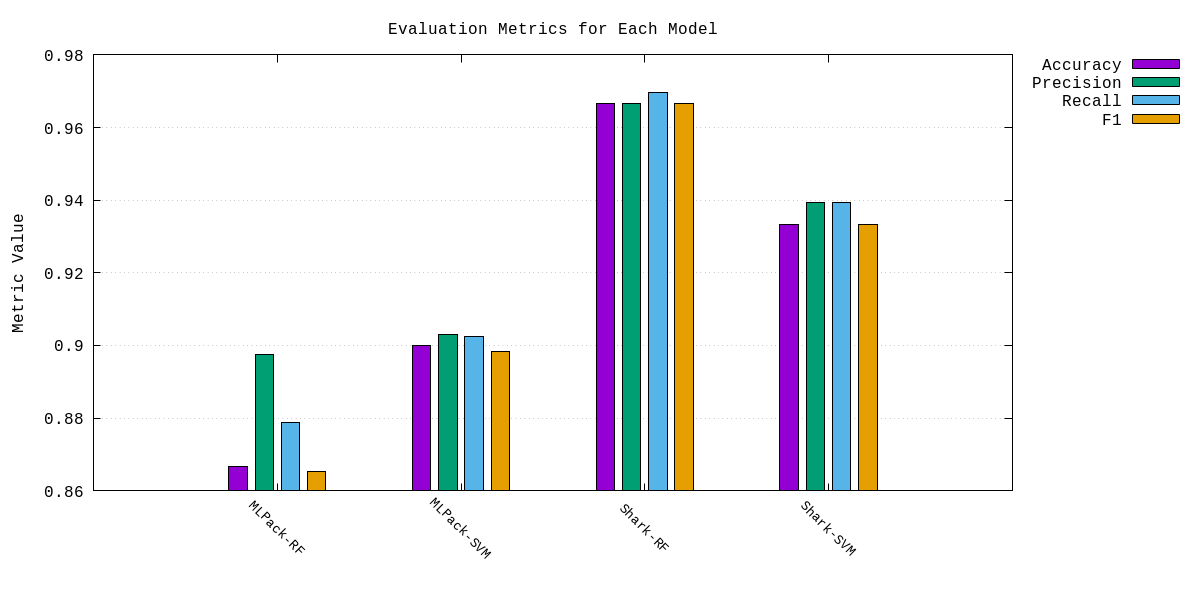

In [37]:
!./plot_metrics


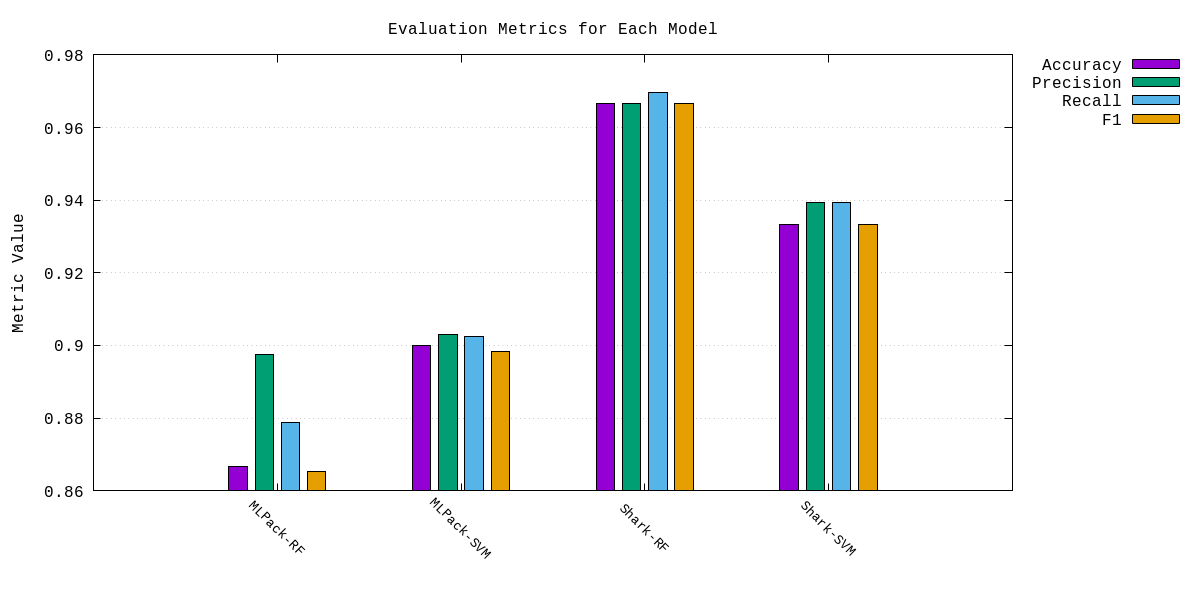

In [38]:
%%html
<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABLAAAAJYCAIAAAD9hIhNAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdf0DNd///8de7nH5JPyQllvQD85t+WfKjZBQzjUZs12Jc1ZjrQjOXYfO5djGfES4Xi9gwbLkuY8aiulKKXMnvZi1qIcxmoVq/db5/nGvnc77hdE51Us799lfv9+v9ep3n+33e6Ty83uf9luRyuQAAAAAA6B+Dp10AAAAAAODpIBACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAtAL9vb2kiRJkjRixIjmf/WAgIA+ffo0/+s+LU9lf3/55ZepU6daWVlJkmRqarp48eJmLqAJRUVFubq6Pu0qREpKiiRJOTk5Gm7/dH/LAAANQyAE0FIEBARIj1i9enWTDJ6amnrp0qUxY8Y0yWh1dO/ePSsrS80GEyZMmDp1qi5e+rHatGljYmJy7949xeLu3bslSYqIiNB8hHr3SL1m3l+FhQsXHjx4cNWqVSkpKQkJCaGhobp+RZ2esQ3W+He/wXT6WwYA0JE2T7sAAPg/ffr0Wbt2reqa7t27N8nIPXr0EEJYWlqWl5c3yYBKv/7665UrV9RvM2fOnKZ90XoZGhrGxcUpYsCuXbtMTU0176vJHqnX/PsrhDh9+nRoaGh4eHhzvqjuztjGaMy73xi6+y0DAOgOM4QAWhBLS8uA/5+jo6MQIjExUZKkb775RnXjl156ycXFRS6XCyHkcvmKFSvc3NxMTU0dHR3feeedqqoqDV+0zuV5p06dkiRJOT+mfuQlS5Z06NBBCOHp6amYIFLNQnfv3lVOHD32EsrDhw97enqamJhYW1tPmjTp+vXryqbZs2cPHz58//79ffv2tbCwGDhw4IkTJzTcIyGEn5/fzp07hRB37txJSUnx8fFRbT169OiwYcMsLS1tbGymT59eVFSk4R5VVlbKZLIvvvji2LFjgwYNMjIykiQpOztbw/1NTU319/dv3759x44dQ0JC8vPzVVvj4+O9vb3btWvXvn374ODggoICDXe2Q4cOkiR99913W7duVRawfft25QZqjrP6ParXk85YocE5qf5otGnTJikpqV+/fm3btvX09MzMzNSwJFHfu6/maAghPvzwQzs7u7Zt244dO/b27dt1RlZz5gAAWikCIYBWYOTIkc8999zu3buVa3755ZcjR47MmDFDkiQhxLZt25YuXbps2bKLFy/GxMRs27ZtzZo1TfLS6keeO3ful19+KYT48ssvL126dOnSpffee0/Zam1trVj52MsXU1JSxo8f7+Pjc/78+UOHDl25cuXFF19UZgZjY+PLly9v3749JSXl559/dnR0nDZtWm1trYZlv/zyy6dOnbp69eqXX345ZMgQKysrZVNGRsbYsWNdXV0zMzP3799/8uTJSZMmabhHxsbGrq6u8fHxISEhr7/++okTJ5KTk5URSP3+ZmZmjho1ysXF5ZtvvomLiyssLPTz8yspKVG0FhQUBAcHT5ky5eLFiydOnJDJZOPHj9dwZ9PT0y9duuTg4PDmm29e+t2ECRM0PM5q9qgx1J856o+GEKK4uPi9995bvXp1cnKyXC6fMmVKk7z76o9GXFzc0qVL582bd/78+alTpy5ZskR1WPVnDgCgtZIDQMswcuRIHx+fchUVFRXK1sWLF5uamhYXFysW161bZ2hoeOPGDcXinTt3zp07p9x46tSpfn5+j77E5MmThw8fXmflggULFDONChkZGUKI06dPazjy6dOnVbd/rNmzZ/fu3bvOyrFjxw4cOFC5eObMGSHEgQMHlFVJknTr1i3FomJ2tKCgQM2rKBkaGiYmJg4ePHjlypU+Pj5bt26dOHFieHi4ojU4OLhHjx41NTWKxaSkJCFEZmamhnvk7+8vhNizZ4+2+zthwoS+ffsqF3Nzc1955ZUzZ84oFr/++msDA4PS0lLF4r17986ePfvw4UNN9leha9eu77777qPr1R9nDffosdSfserPHPVHY8GCBUKI7777TrH4z3/+s6neffVHY9y4caqtUVFRQojvv/9esVjvmaPw2N8yAECLxQwhgBbk5MmTpiratm2rbAoLCysvL//qq68Uizt37nzxxRe7dOmiWOzQoUNycvLgwYOfe+45e3v7/fv3N9XFbLobOTMzc+jQocrFgQMHmpiYKD6gK9jb23fq1ElZhhDi7t27mo//+uuvx8XFXbhwoc40TlZWlr+/v6GhoWLRz8/P2Nj43LlzGg5ramrq4OAwZcoUzStRyMjIGD58uHLRzc1t3759gwYNUiy6u7u3bdt26NChmzZtunr1qpWV1cCBAw0MmuCPVL3HucF7JNSeserPHPVHQwhha2vbq1cvxc+dO3cWTfTuqz8aly9ffuGFF5StqluKRp85AICWiUAIoAXp169fhgrVb825ubn5+Pjs2rVLCHH58uWzZ8+++eabytbFixcvWrQoLCzs+PHj58+fDw4ObqqSdDdycXGxpaWlclGSJHNz8+LiYuUaMzOzOl3kcrnm40+ePPny5cuBgYGqr6J43S1btpj8zszMrLKy8tatW5qP3LNnT8WVulqps791dO7cOT09/fnnn1+yZImbm5u7u/vx48e1fQlNXvfR4ywaukdC7Rmr/sxRfzSEEBYWFqo1i6Z799UcjdLSUtWzTjXfiqY4cwAALRB3GQXQgrRr127w4MFPag0LC4uIiLh9+/bOnTttbW1Vv2O2detWRatiUfW7WPWqkwTq3CCxMSOrZ2VlpRpL5HJ5aWmp6te9GsnGxuaLL75Q3PhRlbW19fjx4+s8ps/GxkbzkRt210o7O7v79++r2aBfv367d++ura09derUihUrRo8effXqVcXkWGNocpwbfB9ONWes+jOn3qPRSE9699UfDTMzswcPHihb60yGN/7MAQC0QMwQAmg1Jk+ebGxsfOjQoX/961+vvfaaTCZTNlVUVHTs2FHx8/3791NSUjQf1sLCQvUj8oULF1Rb6x1ZcQVdTU2N5q+o4O3tnZaWplw8c+ZMRUWF6gV7jffKK6/07t370dfNycnp+bsePXpIkmRra6vcoMF7pJ6np+exY8eUi3l5eR4eHqmpqYrFnJyc9PR0IYSBgYGPj8/mzZsrKiquXbvW+NdthuP8WOrPHPVHo0k86d1XczR69Oih+vzJo0eP1umr/swBALRGzBACaEHu379/5MgR1TXW1tbe3t6Kny0sLIKDgzdu3JiXlzdjxgzVzby8vA4ePDhv3rzy8vIZM2YEBASkp6eXlpaam5sLIXJzcxV3aCwpKSkrK8vJyRFCmJubK76C6O7u/ssvvxw6dGjcuHFnz55VXJWq4chCCEdHR0NDww0bNlRVVdXU1BQUFChry8vLq66uVuxXVVWV4nVNTU27du0qhIiKihoxYsQ777wTGRn5008/RUZGenh4jBo1qsmPah0LFizw8fGZO3eu4kYjGzZs2LNnz/fff6/8QqaaPVJP/f4uWrTI29t71qxZ4eHhVVVV77777oMHD9zd3RV9jx8/vnjx4u3btw8cOLC0tHTDhg0dO3bs379/4/dXp8dZzRmr/sxRfzR0R/3RmDx58owZM5YvX/7yyy+npaX95z//Ue2r/sxR/1sGAGi5nuINbQBA1ciRIx/9N2rIkCGq2yQmJgohvLy86vS9fPmyl5eXqalpr169vvnmm++++87BwaFt27YPHjyQy+V1vgqlMHr0aGX3qKgoW1tbKyurUaNGKeZP/vOf/2gyssLGjRu7dOliaGhoY2MTGBioXK8IQnW4u7srNzh48ODAgQONjIzat28/bdq0n3/+Wdmk/t6n6inuM6m6RvU+k4rDOHjwYBMTk/bt248ZM0Z5c8t690gul48dO3bs2LGPfd169/fo0aNeXl4mJia2travvvqq6m0za2trFU/tMzEx6dChw9ixY8+fP6/Jzqq++mPvMipXe5zV75F66s/Yes8cNUdDp+++mqNRW1v7l7/8xcbGxszMLDg4WHEfUeXNTuVqz5x6f8sAAC2TJNfmS+oAAAAAgGcG3yEEAAAAAD1FIAQAAAAAPUUgBAAAAAA9RSAEAAAAAD1FIAQAAAAAPUUgBAAAAAA9RSAEAAAAAD1FIAQAAAAAPUUgBAAAAAA9RSAEAAAAAD1FIAQAAAAAPUUgBAAAAAA9RSAEAAAAAD1FIAQAAAAAPUUgBAAAAAA91YICYVJSkq+vr5WVlaOjY1hY2L179zTvGx8f7+7ubmxsbGdnN3fu3PLyctXWmJiYAQMGmJubd+rU6eWXX7548WJT1w4AAAAArU9LCYTZ2dlBQUHOzs779u2Ljo5OT0+fOHGihn0TExODgoLc3d0TEhKWL1++ffv28PBwZevmzZvffvvtt99++9KlS/Hx8TU1NSNHjnzw4IFu9gMAAAAAWg1JLpc/7RqEEGLmzJkZGRnZ2dmSJAkhjh075u/vf/r0aQ8Pj3r7BgYG3rt379SpU4rFTz/9dObMmdevX+/SpYsQIjQ0tKCgICMjQ9F64sQJX1/fkydPvvDCCzrbGwAAAABoBVrKDGFKSkpgYKAiDQohhg0bZmZmlpqaqknf/Px8Ly8v5WJgYKBcLk9LS1Msjh8//sKFC//+978fPnxYVla2Y8cOJyenAQMGNPkuAAAAAEDr0uZpF/Bf169fd3R0LCgo6Nat2+jRo48cOdK5c+dr165p0tfe3j4/P1+5WFRUJIQoLCxULIaGhv72229jx459+PBhbW1t3759U1NTTU1N1Y9pbGxcVVXV0L0BAAAAno4WcgEgWosWEQirq6urq6tNTExUV5qYmJSVlWnSferUqZGRkdu2bQsNDb1+/frs2bONjIyUce7kyZMLFiyYP3/+K6+8UlRU9MEHH0ybNi05OVkmk6kZs6qqit8l1EuSWspF12jJOE9QL04SaILzBJpQXnAHaKhFBEKZTCaTySoqKrp27VpeXm5oaCiEKC8vb9u2rSbdZ82adeXKlYiIiJkzZ9rY2Kxdu/bEiROWlpaK1nfffXfo0KErVqxQLPbt27dz58579+6dNm2ajnYHAAAAAFqFlvIdQicnp4KCAkmSTExMZDJZdXX1jRs3XFxcNOlrYGCwevXq0tLSvLy827dve3l51dTU9OrVS9H6ww8/9OnTR7lxp06dLCwscnNzdbIbAAAAANB6tJRAOHLkyMOHD9fW1ioWExISKisrAwICVLcpLi5et27dgQMH6vRNSkpas2aNsbGxs7OzTCaLjY21trb29fVVtDo6On733XfKjQsLCx88eODo6KjLvQEAAACAVqClBML58+ffuHHjjTfeSE5O3rNnT3h4+MSJE5WzfApFRUXz5s2LiYmp07eqqioqKuqvf/1rVlbWypUro6Ojly9fbmRkpGidO3fu4cOHV61a9cMPP/znP/954403OnXqFBIS0kw7BgAAADxDzpw5I0mSq6vr0y7kafJ+3ldqMYZ4DGvMvrSgbyenp6cvXLjw7NmzFhYWISEhH3/8sZmZmeoGqvcgrdP3k08++fjjj2/evOno6Dh//vzIyEjV1l27dq1YseLq1asmJiYjRoyIjo6u9wyW+N42NMB5Ak1wnqBenCTQBOcJNNEM58m8efN27dp19+7dU6dOeXt76/S1WixJkv4hLj3tKv5rjujbmDe9pcwQCiEUz4uvqKj4+eefN27cWCcNCiGcnJzkcvmjaVAIERkZmZ+fX1lZeeXKlTppUAjx2muvXb58uaqqqri4+ODBg3r+/xkAAABAwzx8+PCLL7546623unXrtnv37jqtqamp/v7+7du379ixY0hIiOqT4dS3RkVFqX5EP3XqlCRJWVlZisXKykqZTPbFF18cO3Zs0KBBRkZGkiRlZ2crWuVy+YoVK9zc3ExNTR0dHd955506T4970usmJiZKknT69GnVjcPDw11cXPTqP19aUCAEWp3333//aZeAVoDzBPXiJIEmOE/QEiQkJNy5c2fChAmTJ0+Oi4urqalRNmVmZo4aNcrFxeWbb76Ji4srLCz08/MrKSnRpFU9Y2NjV1fX+Pj4kJCQ119//cSJE8nJycp7gmzbtm3p0qXLli27ePFiTEzMtm3b1qxZo0lVo0aNev7552NjY5UbV1RU7N27NyIiQtKnp3dw7cHjcVUGAAAAWh1df4idNm3a6dOnc3Nzz5496+7uHh8fP2bMGEVTcHBwXl7exYsXFYtXrlxZtGjRe++9N2jQoHpbo6KiDhw4cPXqVUXrqVOnXnjhhdOnT3t4eCjWjBw5UnGrkdDQ0Dol/fzzz7du3RowYICywtu3bycnJ2tSVUxMzDvvvHP79m1zc3MhxBdffDFjxozCwkIbGxv1x4FLRgEAAADol9LS0gMHDkyZMkUIMWjQIGdnZ9WrRjMyMoYPH65cdHNz27dvnyJ31dtaL1NTUwcHB8VL19GhQ4fk5OTBgwc/99xz9vb2+/fvLyoq0rCqP/zhD23atImLi1Msbt++/dVXX603DT5jCIQAAAAA6rdv376ysrJJkybV1NTU1NS88sorBw4cKCsrU7QWFxdbWlo+qa/6Vk307NnzsVdyLl68eNGiRWFhYcePHz9//nxwcLDmr2tmZvbmm28qrhotLCxMSkp69HYkz7w2T7sAAAAAAK3A559/LoTo37+/6sqvv/5acRmnnZ3d/fv3n9RXfWudpFdeXv7oNqampo/tu3Xr1rCwsIiICMVine8lqn9dIcScOXPWrVt36dKlQ4cO9e/ff/DgwWo2fiYxQwgAAACgHrdu3Tp27Nif/vSn0yq6du2qvGrU09Pz2LFjyu3z8vI8PDxSU1M1abWwsCguLla2XrhwQfPCKioqOnbsqPj5/v37KSkpqq3qX1cI4eTk9NJLL3322Wfbtm176623NH/dZwYzhAAAAADqoQh+8+fPV97eUwgRFhb2t7/97e7dux06dFi0aJG3t/esWbPCw8OrqqrefffdBw8euLu7K7ZU3+ru7v7LL78cOnRo3LhxZ8+e3bVrl+aFeXl5HTx4cN68eeXl5TNmzAgICEhPTy8tLVXcJ0b96yr86U9/CgoKMjIymjp1qoYvOqibz5wf+2pepE4N7ufbmO7MEAIAAACox+effx4QEKCaBoUQ06dPf/jw4d69e4UQgwYNOnz48MWLF4cOHTphwgQHB4ekpCRFKqu3NSgoKCoqasaMGdbW1osWLVq3bp0Qora2VpPCNm7caGpq+txzz40ePXru3LkffvihTCazt7dXTDmqf12FESNGtGvXLiws7NEHoT/JmfwT8hYj40KahmU/Fg9XeDweOwEAAIBWhw+xDXD8+HE/P7/c3FwXF5enXctTwCWjAAAAAPTRrVu3Ll68GB4eHh4erp9pUDBD+CT85woAAABaHT7EaiUkJCQhIWHixImK606fdjlPB2fM4/G7BAAAgFaHD7HQFjeVAQAAAAA9RSAEAAAAAD1FIAQAAADQIgQEBPTp06f5++ozAiEAAAAAIYQICAiQfteuXbsXX3wxKyurOQuYMGGC5k+Hb8K+2ho4ZLDUYgwe2qgH0/Ot08eT+D4uAAAAWptGfogNCAi4c+fOhg0b5HJ5YWHhP/7xjwsXLpw/f75nz55NWOQzQJIk8emCp13F72asacybzgwhAAAAgP+ytLQcMWKEn5/f66+/npiYaGpqunHjRkVTZWWlTCb74osvjh07NmjQICMjI0mSsrOzlX2PHj06bNgwS0tLGxub6dOnFxUVqY6cmprq7+/fvn37jh07hoSE5OfnK5vu3r2rnO967GWf8fHx3t7e7dq1a9++fXBwcEFBgeZ9Dx8+7OnpaWJiYm1tPWnSpOvXryubZs+ePXz48P379/ft29fCwmLgwIEnTpxo4IFrtQiEAAAAAB7DwsLCzc3txx9/VCwaGxu7urrGx8eHhIS8/vrrJ06cSE5OdnR0VLRmZGSMHTvW1dU1MzNz//79J0+enDRpknKozMzMUaNGubi4fPPNN3FxcYWFhX5+fiUlJYpWa2vrS5cuXbp0KTQ09NEyCgoKgoODp0yZcvHixRMnTshksvHjxytb1fdNSUkZP368j4/P+fPnDx06dOXKlRdffLGqqkq5R5cvX96+fXtKSsrPP//s6Og4bdq02trapjh4rUabp10AAAAAgJaovLw8Ly/P29tbucbBweHzzz/fs2fPo+nr448/dnV1jY2NNTQ07NGjx6ZNmwICAk6fPu3p6SmEWLlyZc+ePWNjYxUb79y5c9GiRVeuXBk0aJAQwtDQUDG51759+0fLuHjxYnV19R//+Me2bdsKIbZs2fLjjz/W1tYaGBjU23f16tX9+/dfv369YvGzzz5zd3ePj49/+eWXhRAGBga//vprTEyMjY2NEGLWrFkvvfTSjRs3unbt2rgj15owQwgAAADg/9TU1FRXV1+5ciUsLKy4uDgiIkLZZGpq6uDgMGXKlEd7ZWVl+fv7GxoaKhb9/PyMjY3PnTunWMzIyBg+fLhyYzc3t3379inSYL3c3d3btm07dOjQTZs2Xb161crKauDAgYo0WK/MzMyhQ4cqFwcOHGhiYnLmzBnlGnt7+06dOil+7tChgxDi7t27moz8zCAQAgAAAPgvxTWZRkZG3bt3T0tLO3DgQO/evVU36NmzpyRJj3YsLi7esmWLye/MzMwqKytv3bqlbLW0tGxYSZ07d05PT3/++eeXLFni5ubm7u5+/PhxDfvWeV1JkszNzYuLi5VrzMzM6nTRt1tLcskoAAAAgP/q37//1q1bhRDm5uZubm7KGT8lU1PTx3a0trYeP3784sWLVVcqLsUUQtjZ2d2/f7/BVfXr12/37t21tbWnTp1asWLF6NGjr1692rlz53o7WllZqcY/uVxeWlpqZWXV4EqePcwQAgAAAPgvc3NzDw8PDw+Pnj17PpoG1fD29s7Jyen5ux49ekiSZGtrq2j19PQ8duyYcuO8vDwPD4/U1FRNRs7JyUlPTxdCGBgY+Pj4bN68uaKi4tq1axpWlZaWplw8c+ZMRUXFCy+8oPl+PfOYIQQAAADQWAsWLPDx8Zk7d254eLhcLt+wYcOePXu+//77Ll26CCEWLVrk7e09a9as8PDwqqqqd99998GDB+7u7oq+eXl51dXVQoj79+9XVVXl5OQIIUxNTRU3dzl+/PjixYu3b98+cODA0tLSDRs2dOzYsX///pr0jYqKGjFixDvvvBMZGfnTTz9FRkZ6eHiMGjWqkTvbaWCv2zPWNHKQptLL26Mx3QmEAAAAABrL09MzPj5+6dKlsbGxZmZmXl5eqampijQohBg0aNDhw4eXLl06dOjQdu3a+fn57dq1y9zcXNE6cuRI1Rm/559/Xgjh7u6elZUlhJg1a9avv/46f/78GzdumJube3t7JyQkKO44Wm/foUOHHjhw4P333//73/9ubm4eGBi4du1aDW9Io8ats981coSWQ9K3L01qSJI4MgAAAGhl+BALbfEdQgAAAADQUwRCAAAAANBTBEIAAAAA0FPcVAYAgBbksY971hBfHAIAaItACABAy/LqoTsN6LV3nF2TVwIAeOZxySgAAACAZ5a9vb0kSZIkjRgxQttWfUAgBAAAAKBbAQEB0u+sra0HDx4cFxfXPC+dmpp66dKlMWPGNKD1SYYMGyG1GMOGj2jM8eGSUQAAAAA616dPnw0bNggh7t27t3fv3ilTphgYGISEhOj6dXv06CGEsLS0LC8v17b1SU6mpTbs8n5daORXBpghBAAAAKBzlpaWI0aMGDFiRHBw8J49e7p37646SXj06NFhw4ZZWlra2NhMnz69qKhItW9qaqq/v3/79u07duwYEhKSn5+vbJLL5StWrHBzczM1NXV0dHznnXeqqqqab69aPwIhAAAAgGYlSZKRkdHDhw8VixkZGWPHjnV1dc3MzNy/f//JkycnTZqk3DgzM3PUqFEuLi7ffPNNXFxcYWGhn59fSUmJonXbtm1Lly5dtmzZxYsXY2Jitm3btmbNmqewS60Wl4wCAAAAaA41NTVCiF9//XXbtm3Z2dnvv/++Yv3HH3/s6uoaGxtraGjYo0ePTZs2BQQEnD592tPTUwixcuXKnj17xsbGKjbeuXPnokWLrly5MmjQICHE+PHjPTw8BgwYIIRwc3MLDAxMTEz8y1/+8nT2sBUiEAIAAADQuRMnTshkMsXPjo6OMTExymnArKyscePGGRoaKhb9/PyMjY3PnTunCIQZGRmqXzV0c3Pbt2+fcrFDhw67du2KiIi4efNmdXV1cXFx9+7dm2mXnglcMgoAAABA5/r373/69Ol9+/YZGBj8z//8T3h4uLKpuLh4y5YtJr8zMzOrrKy8deuWstXS0vJJwy5evHjRokVhYWHHjx8/f/58cHCwzvfk2cIMIQAAAACdMzc39/Dw8PDwePPNN6OiosaOHduhQwdFk7W19fjx4xcvXqy6vY2NjeIHOzu7+/fvP2nYrVu3hoWFRUREKBaV3y2EhpghBADonQY/66kZRmshe9o85QHQTytXrqytrY2KilKu8fb2zsnJ6fm7Hj16SJJka2uraPX09Dx27Jhy47y8PA8Pj9TUVMViRUVFx44dFT/fv38/JSWlmXbjWcEMIQBAH/1DXNK2yxzR94ltny7QuoIZzXQTvFufNaSXw/SmrgMAfmdjY/Phhx++9dZbf/jDH/z9/YUQCxYs8PHxmTt3bnh4uFwu37Bhw549e77//vsuXboIIRYtWuTt7T1r1qzw8PCqqqp33333wYMH7u7uitG8vLwOHjw4b9688vLyGTNmBAQEpKenl5aWmpubCyFyc3Nra2uFECUlJWVlZZgajNoAACAASURBVDk5OUIIc3NzxcjqW9XoNmhII5/+14T6DR7amO4EQgAAAADNKjw8fOvWrRERERcvXjQxMfH09IyPj1+6dGlsbKyZmZmXl1dqaqoylQ0aNOjw4cNLly4dOnRou3bt/Pz8du3apch7QoiNGzeGhYU999xz3bp1W7VqlbOz86hRo+zt7W/dumVhYTFo0KDffvtN+brPP/+8EGL06NFHjhxRjKymVY38M+lNejyeJkkulz/tGloiSeLIAMAzS5Kkhs0QPvZPgyRJDZshfNJorx66o/VoQuwdZ/fogJIkNXiGkL+DQGvEh1hoi+8QAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAgJ4iEAIAAACAniIQAgAAAICeIhACAAAAeDZ9+OGH0iM+/PDDOpu99dZbkiTdvXtXw2GH9G336LBPyzAv18YcojaN6QwAAAAALdzRo0cNDP5vJszV9b8Jqqys7Ny5c//7v/+blpam1YAns0tvfdaUFTaGw/S8xnQnEAIAAAB4lvn7+7dp85jgM2jQoJs3b77++usfffRReHh48xfWEhAIAQAAAOij+Ph4BwcHY2PjL7/88mnX8tQQCAEAAAA8y3777TdDQ0PloqmpqWKxW7duT6+oloKbygAAAAB4lllZWbVTER8f/7QrakGYIQQAAADwLEtJSVGdIezdu/dTLKalIRACAAAAeJYNGTLksTeVgeCSUQAAAADQWy0oKCclJX3wwQfZ2dkWFhb+/v5r1661trbWsG98fPySJUuys7OtrKwmT568atUqU1NTZeuDBw8WLly4b9++ysrKIUOGbNy40cXFRTc7AQAAAKB1uHr1amlpqRDi2rVrQghFmjA1Ne3Ro4f6jsOHDXWYrt2jC3Vn+PBhjeneUgJhdnZ2UFDQlClTli9ffu/evUWLFk2cODE5OVmTvomJiUFBQbNmzYqOjv7+++8XLlx4//79nTt3KjcIDg6+du3a1q1b27Vrt2TJkqCgoO+//1712ZQAAAAA9E1YWNiJEyeUi35+fkKI3r17Z2dnq++Yknpct5U1o5YSCNetW+fm5rZjxw5JkoQQNjY2/v7+WVlZHh4e9faNjo729vbesmWLEGL48OFGRkYzZ85csWJFly5dhBBHjx5NSUk5d+5c//79hRDOzs7bt2+/f/9++/btdbxPAAAAAJ6mJUuWLFmy5Emt6enpzVlMy9RSZslSUlICAwMVaVAIMWzYMDMzs9TUVE365ufne3l5KRcDAwPlcnla2n/ncA8dOjRgwABFGhRCdOvWbfny5aRBAAAAAGgpgfD69euOjo4FBQWSJI0ZM8bQ0LBz586Ka3nrZW9vn5+fr1wsKioSQhQWFioWL1++3KdPnzVr1ri6unbs2DEwMLDeKWAF6REffPCBEOLMmTPKbXJzc0tKSpSLqk2qP5eUlOTm5j62iREYgREYgRGe4ggN86QaGj+aap0NU+c4NF4rejcZgRH0aoTw8PBHP6wqJ1cAzUlyufxp1yCqq6uNjIw2b9784osvduvWbfTo0UeOHOnXr5+Xl9fWrVvr7b558+bIyMjY2NjQ0NDr169HRERkZGQsW7bsvffeE0J4enreuHHD19d3/vz55eXl77///g8//PD999936NBBzZiS1CKODABAFyRJ+oe4pG2vOaLvY/80SJIkPl2gdREz1jxptFcP3dF6NCH2jrN7dEBJkm591oDBhMN0wd9BoDXiQyy01SK+QyiTyWQyWUVFRdeuXcvLyxVPjSwvL2/btq0m3WfNmnXlypWIiIiZM2fa2NisXbv2xIkTlpaWilZLS8tffvklLi5OMWy/fv0cHBz+9a9/RURE6G6PAAAAAKDlaymXjDo5OSmuFzUxMZHJZNXV1Tdu3NDw4RAGBgarV68uLS3Ny8u7ffu2l5dXTU1Nr169FK1dunRxcHBQpEEhhK2tra2trfKCUgAAAADQWy0lEI4cOfLw4cO1tbWKxYSEhMrKyoCAANVtiouL161bd+DAgTp9k5KS1qxZY2xs7OzsLJPJYmNjra2tfX19Fa2+vr7nz5+/c+e/l9/cunXrzp07rq6uOt4hAAAAAGjpWkognD9//o0bN954443k5OQ9e/aEh4dPnDhROcunUFRUNG/evJiYmDp9q6qqoqKi/vrXv2ZlZa1cuTI6Onr58uVGRkaK1mnTpjk4OLz00ktHjhxJSEh45ZVXOnXqNGnSpGbaMQAAAABoqVpKIHRzc0tISMjLywsKCvrzn//88ssvqz5ZXr2goKBNmzZ99tlnQ4YM+fTTTzdu3Pj2228rW01NTZOTk7t06fLqq68GBwfb2toeP37c3NxcN/sBAAAAAK0GtyF6PG7QBADPMO4yWi/uMgq0UnyIhbZaygwhAAAAAKCZEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABATxEIAQAAAEBPEQgBAAAAQE8RCAEAAABAT7WgQJiUlOTr62tlZeXo6BgWFnbv3j3N+8bHx7u7uxsbG9vZ2c2dO7e8vPyxm0VGRkqS9K9//auJSgYAAACAVqylBMLs7OygoCBnZ+d9+/ZFR0enp6dPnDhRw76JiYlBQUHu7u4JCQnLly/fvn17eHj4o5sdPnz4n//8Z5NWDQAAAACtWJunXcB/rVu3zs3NbceOHZIkCSFsbGz8/f2zsrI8PDzq7RsdHe3t7b1lyxYhxPDhw42MjGbOnLlixYouXboot/n5559nzZoVExMTEhKiu70AAAAAgFakpcwQpqSkBAYGKtKgEGLYsGFmZmapqama9M3Pz/fy8lIuBgYGyuXytLQ01W1mzpwZFhY2YsSIpisZAAAAAFq3lhIIr1+/7ujoWFBQIEnSmDFjDA0NO3fufO3aNU362tvb5+fnKxeLioqEEIWFhco1MTExP/300/Lly5u8bAAAAABovVpEIKyurq6urjYxMVFdaWJiUlZWpkn3qVOnfvvtt9u2bSsrK8vJyZk9e7aRkVFVVZWiNTc39/3339+9e7dMJtOqKukRH3zwgRDizJkzym1yc3NLSkqUi6pNqj+XlJTk5uY+tokRGIERGIERnuIIDfOkGho/mmqdDVPnODReK3o3GYER9GqE8PDwRz+sKq+2AzQnyeXyp12DEEIYGRmtXr367bffrqysNDQ0lMlkbm5uQUFB69evr7dvbW3twoUL169fX1NTY2Njs3bt2hkzZqxdu3bOnDnV1dU+Pj5vvfXW9OnThRB37961tbX95z//OWnSJPVjSlJLOTIAgCYnSdI/xCVte80RfR/7p0GSJPHpAq2LmLHmSaO9euiO1qMJsXec3aMDSpJ067MGDCYcpgv+DgKtER9ioa0WMUMohHByclJcL2piYiKTyaqrq2/cuOHi4qJJXwMDg9WrV5eWlubl5d2+fdvLy6umpqZXr15CiMuXL2dlZc2aNatNmzZt2rSxt7cXQkyePHnw4MG63R8AAAAVj53M0UQzjAZAn7WUu4yOHDny8OHDq1evNjAwEEIkJCRUVlYGBASoblNcXPzpp586OTlNmDBBdX1SUtKFCxcWLFjg7OwshIiNjbW2tvb19RVC9OjR49Kl//s/4Pv37w8dOnT16tXjx49vjr0CAABQatBM8pNaGjCTvHecndYFAHjWtZRAOH/+/B07drzxxhvTp0//6aefFi5cOHHiRMUsn1JRUdG8efNGjx5dJxBWVVVFRUWVlZUFBgYmJiZGR0evX7/eyMhICGFiYtKnTx/llnfv3hVCPPfccxrOPQIAAADAM6ylXDLq5uaWkJCQl5cXFBT05z//+eWXX965c6eGfYOCgjZt2vTZZ58NGTLk008/3bhx49tvv63TagEAAADgGdBSZgiFEL6+vidPnlSzgZOT05O+IxsZGRkZGVnvS3To0IFv2QIAAACAQkuZIQQAAAAANDMCIQAAAADoKQIhAAAAAOgpAiEAAAAA6CkCIQAAAADoKQIhAAAAAOgpAiEAAAAA6Cmtn0N4+vTpc+fO3bp1a/bs2ba2tjdv3uzcubMuKgMAAAAA6JQWgbCoqGjSpEnHjh0zNjaurKycMmVKUVGRp6dnWlpa//79dVciAAAAAEAXtLhkdMGCBTdv3kxKSiorKzM2NhZCdO/ePTQ0dMmSJTorDwAAAACgK1rMEB48eHD//v3Dhg1TrpEkafbs2QEBATooDAAAAACgW1rMEFZXV9vZ2dVZaWhoWFJS0qQlAQAAAACagxaBsE+fPqtWrXr48KHqyk8++WTAgAFNXRUAAAAAQOe0uGR02bJl48aNO3nypL+/f01NzYoVK3Jycs6dO3fkyBHd1QcAAAAA0BEtZgjHjBlz/PjxXr16HTp0yNzcPC0tzdnZOSMjY+TIkbqrDwAAAACgI9o9h9DHx+err77SUSkAAAAAgOakxQwhAAAAAOBZosUMYVZW1mPX19bWenl5NVE9AAAAT58kSQ3uK5fLm7CSZqBXOwugDi0Coaen55Oa+LcAAAA8Y/4hLjWg1xzRt8kraQa3PmtIL4fpTV0HgGanRSDMyMhQXSwvL79w4cLnn3++fv36pq4KAAAAAKBzWgTCwYMH11nj5+fn4+OzbNkynjwBAAAAAK1OY28q4+XllZmZ2SSlAAAAAACaU2MD4cGDB42NjZukFAAAAABAc9LiklFXV9c6a4qLi3/55ZeFCxc2aUkAAAAAgOagRSCcMGGC6qIkSRYWFh4eHoGBgU1dFQAAAABA57QIhKtXr9ZdHQAAAACAZtbY7xACAAAAAFqpxgbCwsLCMWPGNEkpAAAAAIDm1NhAWFpaevTo0SYpBQAAAADQnLhkFAAAAAD0VP03lRkxYoSa1rKysiarBQAAAADQjOoPhKmpqWPGjLG0tHxsa0lJSVOXBAAAAABoDho9duLjjz/u06fPY5tycnK+/fbbJi0JAAAAANAc6v8OoZ2dnUwma4ZSAAAAAADNqf4Zwp9++klNq4GBQdu2bZuuHgAAAABAM2nsXUa7d+9eWlraJKUAAAAAAJpTEzx2ori4uPGDAAAAAACaWWMDYUlJiYODQ5OUAgAAAABoThrdZVShsrJyzZo1SUlJRUVFypU3b95s3769DgoDAAAAAOiWFjOEf/nLX9asWdOpU6fc3NzevXs7Ojrm5+cPGzbs6NGjuqsPAAAAAKAjWgTCvXv37tmzZ/fu3RYWFmvWrDl48OC1a9dKS0t//PFH3dUHAAAAANARLQLh3bt3XV1dhRBt2rSprKwUQlhbW2/btm3hwoW6qg4AAAAAoDNaBMJOnTplZmYqfkhMTFSsNDExYYYQAAAAAFojLW4qExYW9tprr/Xq1Wvy5MlvvfVWZmZmx44dDx482LdvX93VBwAAAADQES0C4bJlyxwcHBwcHObPn3/37t2tW7dWVFR4eXlt3LhRd/UBAAAAAHREi0AoSdKsWbMUP3/00UcfffSRbkoCAAAAADQHjb5DuHfv3oqKCl2XAgAAAABoThoFwsmTJ9vZ2c2YMePf//53bW2trmsCAAAAADQDjQLhqVOn3nzzzcTExICAAEdHx3feeef8+fO6rgwAAAAAoFMaBUJvb+/o6Ojr16+np6e/8soru3fvHjhwYJ8+fT766KPr16/rukQAAAAAgC5o8RxCSZKGDBny97//vbCwMCUlZcSIEZ988omTk9Pw4cN1Vx8AAAAAQEe0uMuokoGBwfDhw83NzW1tbWNjY48fP97kZQEAAAAAdE3rQHjhwoW4uLi4uLj8/HxnZ+fp06e//vrruqgMAAAAAKBTmgbCy5cvK3LgDz/8YGNjExIS8tprrw0ZMkSnxQEAAAAAdEejQNi3b9/s7GwTE5Nx48atWrUqKChIJpPpujIAAAAAgE5pFAhtbW23bt0aEhJiYWGh64IAAAAAAM1Do0CYnJys6zoAAAAAAM1Mi8dOAAAAAACeJQRCAAAAANBTBEIAAAAA0FMEQgAAAADQUy0oECYlJfn6+lpZWTk6OoaFhd27d0/zvvHx8e7u7sbGxnZ2dnPnzi0vL68z8pAhQywsLBwcHKZMmZKfn9/UtQMAAABA69NSAmF2dnZQUJCzs/O+ffuio6PT09MnTpyoYd/ExMSgoCB3d/eEhITly5dv3749PDxc2ZqZmRkYGOjs7Pz111///e9/P3/+/JgxY6qqqnSzHwAAAADQamj02IlmsG7dOjc3tx07dkiSJISwsbHx9/fPysry8PCot290dLS3t/eWLVuEEMOHDzcyMpo5c+aKFSu6dOkihIiJiXFyctqxY4eBgYEQwtraOiAg4OLFi5qMDAAAAADPsJYyQ5iSkhIYGKhIg0KIYcOGmZmZpaamatI3Pz/fy8tLuRgYGCiXy9PS0hSLW7duPXv2rCINCiHMzMyEEA8fPmzK6gEAAACgFWopgfD69euOjo4FBQWSJI0ZM8bQ0LBz587Xrl3TpK+9vb3q1wKLioqEEIWFhYpFAwODdu3aKX6ura1dvnx5v379PD096x1WesQHH3wghDhz5oxym9zc3JKSEuWiapPqzyUlJbm5uY9tYgRGYARGYISnOELDPKmGxo+mWmfD1DkOjdeK3s2mHaHxdPpeNF6d49B4LfndfCZHCA8Pf/TDqnJyBdCcJJfLn3YNorq62sjIaPPmzS+++GK3bt1Gjx595MiRfv36eXl5bd26td7umzdvjoyMjI2NDQ0NvX79ekREREZGxrJly9577z3VzR4+fPjHP/5x37596enpffr0UT+mJLWIIwMA0AVJkv4hLmnba47o+9g/DZIkiU8XaF3EjDVPGu3VQ3e0Hk2IvePsHh1QkqRbnzVgMOEwXej538GGnSSiZZ8njz1JBOfJs4UPsdCWdjOEJSUl586dUy6mpqb+9ttvjS9CJpPJZLKKioquXbuWl5d/8803Qojy8vK2bdtq0n3WrFnz58+PiIho27atr6/vm2++WVtba2lpqbrNb7/9FhwcfOjQoeTk5HrTIAAAAADoAy0C4dWrV3v37v23v/1NuWbBggUDBw68ceNG4+twcnJSXC9qYmIik8mqq6tv3Ljh4uKiSV8DA4PVq1eXlpbm5eXdvn3by8urpqamV69eyg2KioqGDRt27dq106dPDxo0qPHVAgAAAMAzQItAuGjRos6dO69cuVK5Ji4uztbWdtGiRY2vY+TIkYcPH66trVUsJiQkVFZWBgQEqG5TXFy8bt26AwcO1OmblJS0Zs0aY2NjZ2dnmUwWGxtrbW3t6+uraC0vL3/xxReNjIxSU1MdHR0bXyoAAAAAPBu0eOxEamrq3r173dzclGtcXFxWrVoVEhLS+Drmz5+/Y8eON954Y/r06T/99NPChQsnTpyoOssnhCgqKpo3b97o0aMnTJigur6qqioqKqqsrCwwMDAxMTE6Onr9+vVGRkaK1uXLl1+8ePGrr74qKChQdnFwcOjYsWPjywYAAACA1kuLQFhTU2NiYlJnpYmJyYMHDxpfh5ubW0JCwsKFC4OCgiwsLEJCQj7++GMN+wYFBW3atOnjjz/+8MMPHR0dN27cGBkZqWyNi4urrq5+6aWXVLusXLmySSY2AQAAAKD10iIQDhgwYMeOHS+88ILqys2bNw8YMKBJSvH19T158qSaDZycnJ5006TIyEjVEKjqxx9/bILiAAAAAOCZo0UgXLZs2ejRozMyMoYPH25hYXH//v3k5OQrV658++23uqsPAAAAAKAjWgRCPz+/tLS0FStW7N27t7i42M7OztPTc9euXdy3EwAAAABaIy0CoRDC29v766+/1lEpAAAAAIDmpN2D6QEAAAAAz4zGBsJr1655eHg0SSkAAAAAgObU2EBYXl5+5syZJikFAAAAANCcuGQUAAAAAPRU/TeV6dOnz9SpUxcvXtynT59HW6uqqnRQFQAAAABA5+oPhPb29hYWFkKI7777LjQ0tH379qqt9+/fv3Lliq6qAwAAAADoTP2BMCkpSfnzo/OEOTk5u3fvbvq6AAAAAAA6xncIAQAAAEBPafFg+l9++cXa2rrOSplM1rVr1yYtCQAAAADQHLQIhB06dHh0pYuLS0FBQZOVAwAAAABoLlwyCgAAAAB6SotAmJ2dXVxcrLtSAAAAAADNSdNA+PDhw759+545c0an1QAAAAAAmo2mgdDQ0FAmk5mbm+u0GgAAAABAs9HiktGePXtmZGTorhQAAAAAQHPS4i6j0dHRU6ZM6dix4+TJkyVJ0l1NAAAAAIBmoN1zCIOCgkJDQ6Oionr06GFqaqpsOnTokA5qAwAAAADokBaB8A9/+IOrq6u/v79qFAQAAAAAtFJaBMLS0lJjY2PdlQIAAAAAaE5a3FSGNAgAAAAAzxItAiEAAAAA4FlCIAQAAAAAPaVFIJwzZ87t27frrNy2bdtLL73UpCUBAAAAAJqDFoFw48aNv/76a52Vzz333OnTp5u0JAAAAABAc2jsJaPGxsZFRUVNUgoAAAAAoDlp9NiJrKwsxQ/fffddRUWFcn1NTU1MTIy9vb1OSgMAAAAA6JJGgXDatGm5ublCiClTptRpMjQ03LhxY9PXBQAAAADQMY0C4Q8//HD37l1bW9svv/zSxcVFud7Q0NDR0dHGxkZn5QEAAAAAdEWjQCiE6NChw3vvvefn59exY0edFgQAAAAAaB6aBkIhxIcffqi7OgAAAAAAzYwH0wMAAACAntJihlDh9OnT586du3Xr1uzZs21tbW/evNm5c2ddVAYAAAAA0CktAmFRUdGkSZOOHTtmbGxcWVk5ZcqUoqIiT0/PtLS0/v37665EAAAAAIAuaHHJ6IIFC27evJmUlFRWVmZsbCyE6N69e2ho6JIlS3RWHgAAAABAV7SYITx48OD+/fuHDRumXCNJ0uzZswMCAnRQGAAAAABAt7SYIayurrazs6uz0tDQsKSkpElLAgAAAAA0By0CYZ8+fVatWvXw4UPVlZ988smAAQOauioAAAAAgM5pccnosmXLxo0bd/LkSX9//5qamhUrVuTk5Jw7d+7IkSO6qw8AAAAAoCNazBCOGTPm+PHjvXr1OnTokLm5eVpamrOzc0ZGxsiRI3VXHwAAAABAR7R7DqGPj89XX32lo1IAAAAAAM1JixlCAAAAAMCzRKMZwoiICPUbxMTENEUxAAAAAIDmo1Eg3Lx5s6mpqY+Pj5WVla4LAgAAAAA0D40C4e7duz///POUlJQhQ4aEhoZOmjTJ0tJS15UBAAAAAHRKo+8QTp06NT4+vqCg4KWXXtq2bVvnzp1DQkK+++47XRcHAAAAANAdLe4yamdnN3bs2PLy8vLy8oMHD4aGhvbu3Vt3lQEAAAAAdEqjGcJ79+7FxMT4+Ph0797966+/njVr1u3bt1955RVdFwcAAAAA0B2NZgjt7e3btGnj7++/ZcsWJycnIcTZs2dVNwgICNBFcQAAAAAA3dEoED58+PDhw4fx8fHx8fGP3aCmpqZJqwIAAAAA6JxGgZC8BwAAAADPHo2+QwgAAAAAePZocZdRANA3kiQ1uK9cLm/CSgAAAHSBQAgAan26oCG9Zqxp6joAAACaHoEQAJoJ840AAKClIRACQPN59dCdBvTaO86uySsBAAAQ3FQGAAAAAPQWgRAAAAAA9FSrCYRJSUm+vr5WVlaOjo5hYWH37t3TvG98fLy7u7uxsbGdnd3cuXPLy8t1VycAAAAAtBatIxBmZ2cHBQU5Ozvv27cvOjo6PT194sSJGvZNTEwMCgpyd3dPSEhYvnz59u3bw8PDdVotAAAAALQKreOmMuvWrXNzc9uxY4fiHn02Njb+/v5ZWVkeHh719o2Ojvb29t6yZYsQYvjw4UZGRjNnzlyxYkWXLl10XjcAAAAAtGCtY4YwJSUlMDBQecf2YcOGmZmZpaamatI3Pz/fy8tLuRgYGCiXy9PS0nRSKAAAAAC0Hq0jEF6/ft3R0bGgoECSpDFjxhgaGnbu3PnatWua9LW3t8/Pz1cuFhUVCSEKCwt1VSsAAAAAtBKtIBBWV1dXV1ebmJiorjQxMSkrK9Ok+9SpU7/99ttt27aVlZXl5OTMnj3byMioqqqq3o7SIz744AMhxJkzZ5Tb5ObmlpSUKBdVm1R/Likpyc3NfWwTIzACIzTtCI/+5mpIfQ0NoGYvGqbVvRetYoSGeVINjR+tkWedeOQ4NF4rejebdoTG0+l70XiN/1eujpb8bj6TI4SHhz/pzxmgFUkulz/tGupnZGS0evXqt99+u7Ky0tDQUCaTubm5BQUFrV+/vt6+tbW1CxcuXL9+fU1NjY2Nzdq1a2fMmLF27do5c+ao6SVJrePIAKhDkqR/iEva9poj+j72V16SJPHpgobUMWPNowNKktTgB9PzL1LTahHnyeNOEtHU54kkSbc+a8BgwmG60POzrmEnA2r6MAAAIABJREFUiWjZ58mT/jHhPHmW8CEW2moFM4RCCCcnJ8X1oiYmJjKZrLq6+saNGy4uLpr0NTAwWL16dWlpaV5e3u3bt728vGpqanr16qXrmgEAAACghWsdgXDkyJGHDx+ura1VLCYkJFRWVgYEBKhuU1xcvG7dugMHDtTpm5SUtGbNGmNjY2dnZ5lMFhsba21t7evr20ylAwAAAEBL1ToeOzF//vwdO3a88cYb06dP/+mnnxYuXDhx4sQ6s3xFRUXz5s0bPXr0hAkTVNdXVVVFRUWVlZUFBgYmJiZGR0evX7/eyMioefcAAAAAAFqc1jFD6ObmlpCQkJeXFxQU9Oc///nll1/euXOnhn2DgoI2bdr02WefDRky5NNPP924cePbb7+t02oBAAAAoFVoHTOEQghfX9+TJ0+q2cDJyelJ36CNjIyMjIzUTV0A8NQ0+G5y3G8AAAAotJpACAB4VANuDOgwXQd1AACA1ql1XDIKAAAAAGhyzBBCf3G5HQAAAPQcgRD6rUHPCNZBHQAAAMBTwCWjAAAAAKCnCIQAAAAAoKcIhAAAAACgpwiEAAAAAKCnCIQAAAAAoKcIhAAAAACgpwiEAAAAAKCnCIQAAAAAoKcIhAAAAACgpwiEAAAAAKCnCIQAAAAAoKcIhAAAAACgpwiEAAAAAKCnCIQAAAAAoKcIhAAAAACgpwiEAAAAAKCnCIQAAAAAoKf+X3v3H9fzvf9//PkukbQyhMolkXAcqctZl+GIVKhlRMqPMdXsnLSVWevY5nLZxA6zaU6cdeTH5ZPy4+DYMJl594NwzBzbkGp+x5BfSbFoqb5/vPZ9n/fRD2+U1yvP2/Wv9+vX+/J463l5e91fz8fr9SYQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJLSUCDMzMz08vJq27atk5NTeHh4SUmJ6ccmJyd7eHhYW1vb29sHBQUdO3bM9K0AAAAAICetBMLjx48HBgZ27979iy++WLx48f79+8eNG2fiscuXL4+JiYmJicnNzd25c+f9+/f9/PxKS0tN2QoAAAAA0mqhdgG/SUxMdHV1TU1N1el0Qoj27dv7+voePnzY09Pzocfu2bPH09Nz2rRpyuLs2bO9vLzy8/MHDhz40K0AAAAAIC2tzBDu2bPnpZdeUtKgEGLIkCFWVlY5OTmmHDt69OijR49mZWVVVVWVl5enpqY6Ozt7eHiYshUAAAAApKWVGcILFy44OTkVFhZ269bN39//m2++cXR0PH/+vCnHTpo06Zdffhk5cmRVVVV1dbWbm1tOTk7r1q1N2QoAAAAA0tLEDGFlZWVlZaWlpaXxSktLy/LyclMOP3DgwDvvvBMbG/vtt9/u3LnTyspq8uTJlZWVpmxtgK6W+Ph4IcT3339v2OfkyZO3b982LBpvMn59+/btkydP1rmJd1D3HR6P1j4F71B70+NpoIbH0MCneDz1/Ts8+btp/K/ZpO/weJr0b/GE79Yo33LGmtFfs3Hf4ck16d/iyT35t9wDtPzXfCbfITIysvbJqqHbDjCdrqamRu0ahBCiZcuWCQkJMTExFRUV5ubmFhYWrq6ugYGBS5YseeixgwcPtrW1TU9PVxaLioocHR3XrFkzefLkh26tj06nlX8ZNB2dTif+751HPuy1zxgbWqbT6T4XuY96VLRwq/PP+piDRNQ9TnQ63fj0q4/xZpte7lRfeZdTHvndHCIEY1gT46SeL5PGHSePN0gE4+RxB4nQ9jhp3C8TwTjRJE5i8ag0MUMohHB2di4sLNTpdJaWlhYWFpWVlT///LOLi4spx544caJv376GRXt7exsbG8MVlIa3AgAAAIC0tBII/fz8duzYUV1drSzq9fqKiophw4YZ71NWVpaYmLh169YHjnVycsrLyzMsXrx4sbS01MnJyZStAAAAACAtrQTC2NjYn3/+OSwsLDs7e/369ZGRkePGjevTp4/xPjdv3nz77beTk5MfOHbGjBk7duz45JNPTpw48d1334WFhdnb24eGhpqyFWgsdfbxm0LtwgEAACAvrTxl1NXVVa/Xz5o1KzAw0MbGJjQ0dNGiRSYeO3XqVDMzswULFnzwwQeWlpZDhw7du3evjY2NKVuBRvR4t3M0RSUAAACAKbQSCIUQXl5eBw4caGAHZ2fn+u6RnTJlypQpU+o7sOGtAAAAACAnrbSMAgAAAACeMgIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAIKkWahcAmEqn0z32sTU1NY1YCQAAAPBsIBCiOflc5D7GUdHCrdErAQAAAJ4BtIwCAAAAgKQIhAAAAAAgKQIhAAAAAEiKewgBLXrsJ+jw+BwAAACYjkAIaNTllEc+xCGiCeoAAADAs4uWUQAAAACQFIEQAAAAACRFIAQAAAAASREIAQAAAEBSBEIAAAAAkBSBEAAAAAAkRSAEAAAAAEkRCAEAAABAUgRCAAAAAJAUgRAAAAAAJEUgBB5ffHy82iWgGWCc4KEYJDAF4wRAUyAQAo9v7ty5apeAZoBxgodikMAUjBMATYFACAAAAACS0lAgzMzM9PLyatu2rZOTU3h4eElJienHJicne3h4WFtb29vbBwUFHTt2zHhraWlpZGRkhw4dnnvuuYCAgDNnzjR27QAAAADQ/GglEB4/fjwwMLB79+5ffPHF4sWL9+/fP27cOBOPXb58eUxMTExMTG5u7s6dO+/fv+/n51daWmrYYezYsZmZmatWrdq6dWtpaWlgYGB1dXXTfA4AAAAAaDZaqF3AbxITE11dXVNTU3U6nRCiffv2vr6+hw8f9vT0fOixe/bs8fT0nDZtmrI4e/ZsLy+v/Pz8gQMHCiF27dq1Z8+eH3/80d3dXQjRvXv31atX37p1q127dk35gQAAAABA67QyQ7hnz56XXnpJSYNCiCFDhlhZWeXk5Jhy7OjRo48ePZqVlVVVVVVeXp6amurs7Ozh4aFsTU9P9/DwUNKgEKJbt25z584lDQIAAACAqNEGCwuLJUuWnDt3Tgjh7+9fU1Pj6uoaExNj4uErV65s1apVixYtzMzM3N3dz58/b9jk6+v76quvJiQkuLi42NnZBQQE5ObmPvQN1f6zAAAAAI/j8c7GIS1NtIxWVlZWVlZaWloar7S0tCwvLzfl8AMHDrzzzjuxsbHBwcE3b96Mj4+fPHlydna2hYWFEKKsrCwvL6+8vDwtLe3u3btz5szx8fEpKCjo0KFDA+9ZQyYEAAAA8KzTRCC0sLCwsLC4d+9e165d7969a25uLoS4e/dumzZtTDn83XffHTx48IIFC5RFNzc3R0fHTZs2TZ48WQhha2t7/fr1jRs3Km/br18/BweHzZs3T58+vck+EAAAAAA0A1q5h9DZ2bmwsFCn01laWlpYWFRWVv78888uLi6mHHvixIm+ffsaFu3t7W1sbE6ePKksdunSxcHBQUmDQgg7Ozs7O7uLFy82+kcAAAAAgOZFK4HQz89vx44dhl+D0Ov1FRUVw4YNM96nrKwsMTFx69atDxzr5OSUl5dnWLx48WJpaamTk5Oy6OXldeTIkatXryqLly9fvnr1ao8ePZrqkwAAAABAM6HTyM1yp06dcnd3HzduXERExJUrV2bNmjVgwIDNmzcb71NYWNitWzd/f/9vvvnGeH1aWlp4ePjHH388ZsyYW7duzZ49u6Cg4KeffrKxsRFC3L17183NrV27dvPmzTMzM/vwww8vXrz4008/WVtbP9VPCAAAAAAao5UZQldXV71ef+bMmcDAwJkzZwYFBaWlpZl47NSpU9PS0lJTU93c3IYPH96mTZu9e/cqaVAI0bp16+zs7C5duowfP37s2LF2dnZ79+4lDQIAAACAVmYIAUA71q9fb29v7+Pjo3YhAAAATUsTTxkFAO1Yt27da6+95uLikp+fr3YtAAAATYtACAD/tW7duri4uP79+4eGhqpdCwAAQJPTyj2EwFO2fv363bt3q10FtEVJgytXrjxz5sy0adOEEEVFRd9//73adQEAADQVAiFktG7duoiIiDfffFPtQqAhShrU6/V6vT46Ovry5cuRkZF9+vTx8fG5ceOG2tUBaN5++OGHSZMmRUZGnj59Wu1aAOB/EAghHUNPYFRUlNq1QCsMadDBweGf//znsWPHRo0aZWtr26pVq2XLlnXo0EHtAgE0Y8XFxcOHD7e2tu7UqZOXl9e3336rdkUA8F88ZRRyMfQERkZGnjp1ysrKqqio6PLlyy+88ILapUE1ubm5I0aM0Ov1bm5uhw8fjo6Ofvvtt3v37h0QEJCQkDB58mRlt2vXrnXs2FHdUgE0R9nZ2ePHj79+/bpOp9u1a1d4ePiZM2esrKzUrgsAhGCGEFKhJxB1cnNzO3r0qJubmxDC09Pz4MGDffr0eSANpqSk9OzZk3GCBtATiPp4enr++uuvR44cEUL4+/tbWFjk5OSoXRQA/IZACFnQE4gGGE/9KROGD6TByMjIpKQkxgnqQ08galu6dGlWVpYQwsbGJjY2Ni4uTln/xhtv9OrVSwhx586d6upqNUsEAFpGIQl6AmGi+tJgSkqKYQ1QGz2BqC0qKsrW1nbhwoVCiPLycmdn540bN/r4+ChbS0tL/f39g4ODZ82apWqZAGTHDCGkQE8gTLRr1y7SIB5DfT2BTAHJLCwsLC0traioSAhhZWXl7e2dkZGhbFLSYJs2baKjo1WtEQCEeXx8vNo1AE9DmzZtDK/rmwVasWLFgAEDVCoQmvDHP/6xX79+yuuG0+Dp06dzc3OdnZ2fan3QmKVLl965c6d79+6tWrWqqKhYtWpVWFiYEKKiosLb29vMzGzEiBElJSWDBg1Su1KooEuXLjU1NTNmzPjd736Xn5+fkJDw+uuv9+3bV0mD1tbW27dvZxoZgOpoGYV06AmEKR6aBn18fEpKSrZv325oAIOEGugJNEwBcdIvubVr186fP//atWvR0dFz585VBkZ+fv706dODg4O5CglAdbSMQjr0BMIUFy5c6NKli7+/f+1NShr09vZOT0+fOHHivn37nn550Ij6egKZAoLBlClTCgoKiouLDWmwpqZm+/btXl5eoaGhX375pdoFApBdC7ULAJ42w3PehAmzQJcuXfL29n6K1UEr5syZU1NT4+vrm52dbfxwUUMaTE1NNTc3T0lJCQkJOXv2rHFPMuQxYMCA2NjYoUOHJiUl3bt3LyMjIyQkxHgK6NixY0wBQVF70vinn35avHhxcHCw2qUBkBqBEPKiJxANU26xNs6Eyqi4ffu2nZ2dubm5ECIwMNDW1jYnJycwMFDdaqGWuLi4zp07x8TEXLt27a233goICDBMAZWWloaGhi5ZsoQzflRUVDyQBu/fv//VV1/17dtX7dIAyI6WUciLnkA8VHx8/Lhx4/bs2SOMRsXZs2cPHDgQERFx6dKlHTt2FBYWOjg4qF0p1GToCYyNjVVO+nfv3u3t7T169OiYmJjFixerXSDU16pVq6ioKOM0OGnSpLKysk8//VRZPHjwYHFxsdplApARD5WB1OLj47/88suGewK//vrriIgIegIlV1JS0q9fP8OouH37dlRU1L/+9S8hxLx589599121C4T6lCeLPjAFNHTo0L59+yYnJ6tdHTRESYMnTpzIysqys7MTQnz99devvvpqVVVVUlISN7QDeMoIhJDdA5nQ0BMYERHxt7/9TdmnZ8+eiYmJ9ARK7ssvvwwKClI6RRV3795t0aKFhYWFilVBU1JTU0NDQ42ngE6cOLF//34bGxu1S4NWVFdXT5gwwZAG8/LyLly44Ovra25ufu7cOW9v7y1btvTv31/tMgFIhJZRyI6eQJgoODjYOA0KIVq3bm1hYUGvFwzCwsIeSINZWVlKGmScQGFmZubr66ukwYyMDA8Pj+nTp/fu3Ts/P9/V1dXLy2vLli1q1whALgRCQMyZMyckJKSkpMTQKdquXbvMzMzKysru3bsHBwd/9NFHHh4eapcJjdLr9SNHjnRxcVm3bp3atUATqqurH2gIFIwTGImKilIGRmpq6rRp086fPz9//vwRI0YkJyfzGDMATx8to8B/0ROIR0KvF+qzbNmykJAQ5aSfcYL6rF+/fs6cORkZGc7OzgsXLnz//fc//vjj9957T+26AMiFQAg83P379w8fPuzq6tq+fXu1a4FWZGRkBAYGOjg4mJmZbdu2rV+/fuPHj+/evfvChQvVLg0awjhBw9LS0lJTU9u3b79ly5aPPvrIkAYPHjx47NixP//5z+qWB0AGtIwCD0evF2qj1wumYJygYVOnTs3KyiorKwsLCzOkwRs3brzyyivV1dXq1gZAEgRCoCF5eXk7d+708/O7evXqf/7zn7/85S/fffed2kVBEwIDA7OysgoLC1955ZWZM2dGRUXNmTOnzp+1hMwYJzBFQEBAWVmZ8rqkpMTf3//SpUtr1qzp2bPnxo0b1a0NwDOPllGgXvR6oWH19XrV1NRcunTJ0dFRp9OpWyG0oL5xImgLhJGqqipzc/OSkhI/P782bdqkpKT06NHj8OHDwcHBy5YtGzlypNoFAnhmMUMI1IteLzSszl6vnTt3duvWzdnZuXPnzps3b1a1QGhCneNE0BaI/2VIgx07dszMzOzRo4cQwtPTMz09/cUXXzTslpKSEhkZqV6ZAJ5BBEKgXvR6wRTGvV6ZmZlBQUGvv/76nTt3duzYERsbu3v3bnXLg0YYjxNBWyDqsmnTpo4dO27btq1Vq1aGlf369TP8eElKSsqMGTMmTJigUoEAnk20jAINoScQplB6vaqrq7t27RoVFTV79mxl/apVq9LT07du3WrYMyUl5eDBg8uXL1epUqhJGSdCiIbbAhkkMjMMktqUNLht2zZfX9+nXBWAZxszhEBD6AmEKZQTuPz8/Bs3bsTFxRnWd+nSxXg3ru5LzjgN1tcWyCCRHGkQwNNHIAQejp5AmMLR0dHMzOzChQuGNQEBAWvXrlVecz4HRQNtgQwS1ImBAaBJ0TIKmISeQJgiMTExOTl5/vz5jo6OAwYMMKznfA7G6mwLZJCgTikpKdOmTevatauzs3Pp//fXv/51+vTpapcG4BnRQu0CgObhkXoCt23b9rTrgzbMnDnTyclpyZIlLVu2/Oqrr1q3bi040UctpEGYSBkYer3+3Llza9as+eKLL1q3bm1lZWVlZaV2aQCeHcwQAo+gpKSkS5cuR48eVe78Udy5c8fa2lpwSoe6cHUfD8UgQX0WLFgwYMAAX1/fhQsXXrx48fPPP1e7IgDPIGYIgUfw/PPPz58//+WXXzbuCSQNoj5c3cdDMUjQAMPtCXl5eca/RggAjYiHygCPZubMmQsWLFi6dOkHH3xw9+5dZSVpEHUqKiratm3bsGHDiouL+/Xr161bt86dO9vY2LRowcU4/IZBAlPk5eX17NnTeM2lS5fUKgbAM4aWUeBJ0e6Fh3r11VdffPHFmJgYtQuBdjFI0IB58+ZNnTrV2dlZWTx9+rSXl9dXX33FtCGAJ8cFSOCJ0O4FU+Tl5U2ZMkXtKqBpDBI04MMPPzRe7NGjx+rVq0ePHk0mBPDkaBkFngjtXjDFmDFjevXqZVik1wu1PTBIBOMEDQoICFi9enVmZqZhzQ8//DBp0qTIyMjTp0+rWBiAZoeWUaBx0O4FE9HrBVMwTvBIiouLe/bsGRwcbG9vv2LFii1btgwcOFDtogA0D8wQAo2j9h3/QJ0MvV6HDh1SuxZoVwPj5PTp0zk5OapUBc06evSoTqdbsWLFvHnzUlNTg4ODy8vL1S4KQPNAIAQaBz2BMF3tXi9BuxdqqXOcnD592sfHZ+TIkbt371arMGiQp6fnr7/+euTIESGEv7+/hYWFctXg5s2bapcGQOsIhEDj+PDDD42f//bCCy/UOf/DpX0oAgICDL8wJoQoLi4ePny4tbV1p06dvLy8vv32WxVrg3Y8ME6UNOjt7Z2enj5x4sR///vfKtYGLVi6dGlWVpYQwsbGJjY2Ni4uTln/xhtv9OrV686dO+7u7ufOnVO1RgBaxz2EQJP45ptvwsPDH7j/RzmZKykp2b59u4+Pj4rlQWuys7PHjx9//fp1nU63a9eu8PDwM2fO8KxaGDOkwdTUVHNz84yMjIiIiPz8fBsbG7VLg2qioqJsbW0XLlwohCgvL3d2dt64caPh/5eEhITVq1cfO3bMzIwJAAD14gsCaBK1e724tI8G1NnuRa8XDJQvkNu3b9vZ2Zmbmwshhg8f3qFDh127dqldGtQUFhaWlpZWVFQkhLCysvL29s7IyFA2VVRULF68+KOPPiINAmgY3xFAUzHu9TK+tD906NC1a9dOmDChrKxM3QqhugbavRwdHen1gsLwBXL27Nm9e/f+6U9/unnz5tdff11QUNC1a9eKiorvv/9e7RqhjgEDBsTGxg4dOjQzMzM9PT0jI8Pd3V3ZlJKS4uDgMHbsWHUrBKB9BEKgyXFpH/UpKCgwXM6fNWtWbm6u8qSQ9957T6/X29radu3aVdUCob6SkhLD5aR27do5Ojr+8MMP9vb2ISEh8fHx7u7uQUFBQ4YM4Rkz0oqLi/vggw9iYmLCwsLeeuutCRMmCCGqqqoWLVo0f/58w25XrlyZMWMG4wRAbQRCoGk1fGlf7eqgsvravej1gsHzzz+/ZMkS5b7B+/fv5+TkpKSk3L59+9atW7GxsUFBQefPn09NTZ04cSLn+tKaMmVKQUFBcXHx3LlzlTUbNmxwcHDw9/cXQpSUlLz//vsuLi7Hjx/nKwVAbS3ULgB4lhlf2jc3Nzdc2jc3N4+Pj1eeN1NRUXH8+PEXXnhB7WKhAkO7V1JS0r179zIyMkJCQgS9XvhfwcHByotDhw6ZmZn17dvXzMysoqJCSYO7d+/u3Llzp06dQkJCNmzYwAOrUFNT88knnyQlJf3yyy+JiYmfffbZ4MGDs7Oz+/fvL4RYv369vb094wSAAYEQaELKpf2goCDDpf19+/b17t1bCNGyZUshhHJKt2/fvvT0dP57llNcXFznzp1jYmKuXbumtHspvV7/+Mc/DPtcuXJlwYIFY8eOZZBILjMzc9CgQYY0mJmZ+frrr3fu3FkIMXjw4M2bN0+ZMiU3N5fnjkpu+/btrq6uubm5EydO9PHx2bdv3+9//3tl07p161577TUXF5f8/Hx1iwSgHXQOAE0rODhYuW/QcGm/ZcuWxmmQdi880O5Frxfq89xzzw0ePNjw1ZGXl/fjjz/GxsYqWwcPHpyXl0caxPnz5w8dOpSbm7t///61a9cap8G4uLj+/ftHRUWpWyEATeF3CIGnZN68eYcOHUpPT1cWH2j32rdvH+1eEELU1NS4u7snJSX94Q9/MPR6zZ49m14vKEpLSydMmGD46igtLR0xYsSgQYMWL16sdmnQkFu3brVt29Z4jZIGV65cGRkZeerUKSsrq6KiosuXL3PDAgCuNwNPiXJpX3ltaPfy9vY2bvcKDw/ntygkZ+j16tmzZ0FBwb59+7Zt26akwXXr1kVERLz55ptq1wg12drajho1SkmDyqJery8sLLx27ZrapUFD6kyDer1er9dHR0dfvnw5MjKyT58+Pj4+N27cUKtIABrBDCHw9Ny5c8fa2towN7h169apU6caX9pXdlC3SKjr73//+6effvryyy/PmjWrW7duhvXK+Zyrq2toaGhMTIyKFQJoXgxp0MHBoXfv3sOGDTty5MioUaPS0tI+++yzyZMnq10gAJURCIGnqqqqauTIkbR7oQH0egFoLLm5uSNGjNDr9W5ubocPH46Ojn777bd79+4dEBCQkJBAGgQgCITA05eUlDRu3Dil3UsIUVpaGhERkZyc3LFjR3ULgzYZru6vXLnS3t4+NDR00aJFmzZtqqqqOnv2bIcOHdQuEICmXbt2zfj/FyUikgYBGBAIAUC76PUC0IhIgwBq46EyAKBRubm5Shp0c3M7d+6ci4vLmDFjNmzYsGbNGtIggEdFGgRQJ2YIAUC76PUC0FgSEhLs7e359gDwAAIhADQPpEEAANDoaBkFgGaANAgAAJoCM4QA0AzQ6wUAAJoCgRAAAAAAJEXLKAAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCITxwmNvAAAA5UlEQVQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACApAiEAAAAASIpACAAAAACSIhACAAAAgKQIhAAAAAAgKQIhAAAAAEiKQAgAAAAAkiIQAgAAAICkCIQAAAAAICkCIQAAAABIikAIAAAAAJIiEAIAAACApAiEAAAAACCp/wckH3Vfxzi7BQAAAABJRU5ErkJggg=='>